# Notebook to experiment with techniques for identifying the borders between layers
The resulting layer borders from each column are then reviewed manually (by looking at the 512 output plots of `LayerPredictor`) and if any borders need correction (maybe a dozen of them), they are manually updated. The results are finally smoothed by convolving with a 3x3 gaussian kernel with $2 \sigma^2 = 1 \text{ idx}^2$ for each layer boundary.

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import json
import os

from caveclient import CAVEclient

from cortical_layers.LayerPredictor import BoundaryPredictor, LayerPrediction, LayerClassifier

# LayerPredictor on the entire dataset

#### Use soma density, soma volume, and standard deviation of soma volume to find the boundaries between layers across all of minnie65
This step can be skipped if you already have a `LayerPrediction` object (`pred`)

In [86]:
resolution = np.array([4., 4., 40.])
# conservative bbox only containing well-segmented areas
seg_low_um = np.array([130_000, 50_000, 15_000]) * resolution / 1_000
seg_up_um = np.array([355_000, 323_500, 27_500]) * resolution / 1_000
name = "minnie65_full"
cache_dir = r".\minnie65_full"

p = BoundaryPredictor(features=("soma_volume",), num_PCA=None, use_depth=False, use_soma_vol_std=True, resolution=resolution, save_figs=True, verbose=True, 
                      name=name, cache_dir=cache_dir)

In [87]:
%matplotlib inline
try:
    pred = LayerPrediction.load(os.path.join(cache_dir, f"{name}_prediction.json"))
except IOError:
    pred = p.predict(np.array([seg_low_um, seg_up_um]), col_size=(100, 100), ngridpts=(32, 16))

In [88]:
# manual modifications based on proofreading all 512 plots
pred.bounds[69][3] = 0.85
pred.bounds[90][3] = 0.82
pred.bounds[91][3] = 0.82
pred.bounds[101][3] = 0.85
pred.bounds[312][3] = 0.81
pred.bounds[442][3] = 0.81

pred.bounds[161:165, 1] = 0.54
pred.bounds[500][1] = 0.5

In [89]:
# smooth out the results and save a copy
smooth_pred = pred.deepcopy()
smooth_pred.name = "smooth_" + smooth_pred.name
p.smooth_bounds(smooth_pred, smoothness=0.8)
smooth_pred.save()

# Classify some points based on the resulting layers
#### Get some inhibitory cell somas in a desired region--we're going to classify these cells by layer

In [7]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v2")

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
bbox /= resolution
def in_bbox(p, bbox):
    """returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

col_cells = auto_cells[auto_cells.pt_position.apply(in_bbox, args=[bbox])].copy()
inh_locs = col_cells.query("cell_type == 'inhibitory'").pt_position.values
inh_locs_nm = np.array([np.array(loc) * resolution for loc in inh_locs])

## Classify!
**All you need in order to classify the layer of some points is the name of the aligned volume or the path to a jsonified LayerPrediction object**

In [10]:
c = LayerClassifier(data="minnie65_phase3")
# ALTERNATIVELY c = LayerClassifier(data=os.path.join(cache_dir, f"smooth_{name}_prediction.json"))
inh_layers = c.predict(inh_locs_nm)

# TODO demonstrate adding a "layer" column to a dataframe of cells

In [12]:
inh_layers

array(['L23', 'L6', 'L5', 'L6', 'L4', 'L5', 'L5', 'L23', 'L5', 'L4', 'WM',
       'L4', 'L6', 'L4', 'L4', 'L4', 'L6', 'L4', 'L5', 'L1', 'L4', 'L6',
       'L4', 'L4', 'L6', 'L5', 'L6', 'L4', 'L6', 'L5', 'L1', 'L5', 'L23',
       'L4', 'L5', 'L5', 'L23', 'L5', 'L6', 'L23', 'L23', 'L6', 'L23',
       'L23', 'L5', 'L5', 'L23', 'L4', 'L6', 'L5', 'L4', 'L5', 'L4', 'L4',
       'L5', 'L6', 'L6', 'L6', 'L23', 'L23', 'L23', 'L23', 'L5', 'L5',
       'L4', 'L6', 'L4', 'L5', 'L4', 'L23', 'L4', 'L1', 'L5', 'L5', 'L4',
       'L6', 'L6', 'L1', 'L6', 'L1', 'L5', 'L23', 'L23', 'L1', 'L23',
       'L5', 'L6', 'L5', 'L23', 'L5', 'L23', 'L4', 'L4', 'L6', 'L23',
       'L4', 'L4', 'L6', 'L5', 'L23', 'L23', 'L23', 'L4', 'L4', 'L5',
       'L6', 'L4', 'L23', 'L5', 'L23', 'L6', 'L5', 'L4', 'L6', 'L5', 'L4',
       'L5', 'L23', 'L4', 'L5', 'L4', 'L23', 'L6', 'L4', 'L23', 'L1',
       'L1', 'L5', 'L4', 'L6', 'L6', 'L4', 'L23', 'L23', 'L4', 'L23',
       'L5', 'L23', 'L1', 'L5', 'L5', 'L5', 'L5', 'L23', 'WM',

<IPython.core.display.Javascript object>


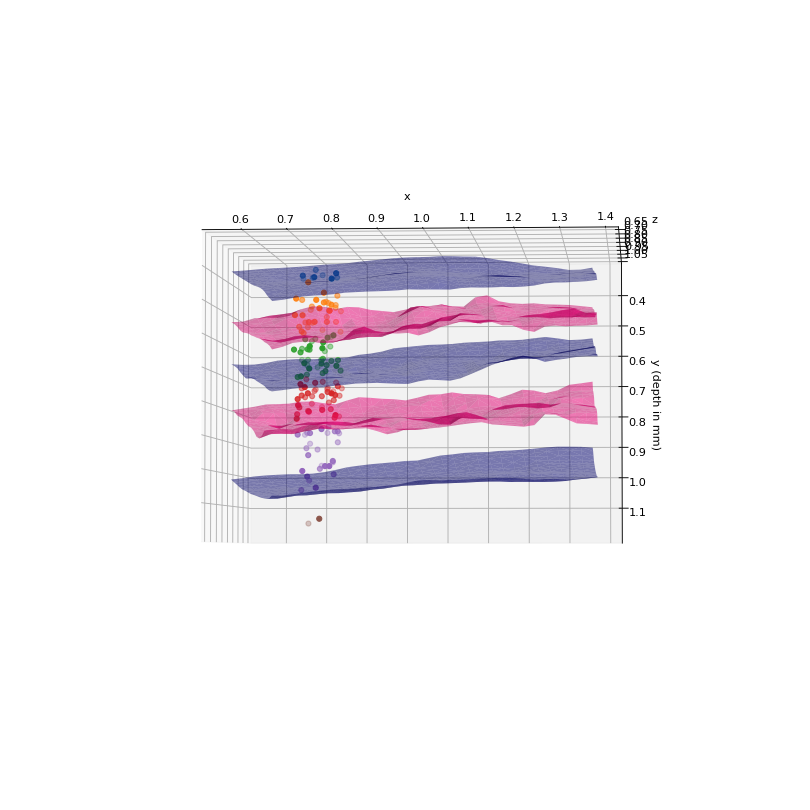

Text(0.5, 0, 'z')

In [90]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
centers = smooth_pred.cols_nm.mean(axis=1) / 1_000_000

# surfaces
for j in range(5):
    ax.plot_trisurf(centers[:, 0], centers[:, 2], smooth_pred.bounds[:, j], color=(j % 2, 0, 0.5, 0.5))

# classified points
for layer in np.unique(inh_layers):
    idxs = inh_layers == layer
    ax.scatter(inh_locs_nm[idxs, 0] / 1_000_000, inh_locs_nm[idxs, 2] / 1_000_000, inh_locs_nm[idxs, 1] / 1_000_000, s=20)
    
ax.invert_zaxis()
ax.set_zlabel("y (depth in mm)")
ax.set_xlabel("x")
ax.set_ylabel("z")

### create layer meshes compatible with neuroglancer

In [75]:
import matplotlib as mpl
from neuroglancer_scripts.mesh import save_mesh_as_precomputed

In [92]:
centers = smooth_pred.cols_nm.mean(axis=1)
tri = mpl.tri.Triangulation(centers[:, 0], centers[:, 2])

for i in range(5):
    v1_verts = np.array([tri.x, smooth_pred.bounds[:, i] * 1_000_000, tri.y], dtype=np.float32).T
    v1_faces = tri.triangles.astype(np.uint32)

    if not os.path.isdir('layermeshes'):
        os.makedirs('layermeshes')
    with open(f'layermeshes/{i}','wb') as fp:
        save_mesh_as_precomputed(fp, v1_verts, v1_faces)
with open(f'layermeshes/0.0','w') as fp:  # this should be 0:0, but 0:0 is not a valid filename in windows, so it's modified
    d = {'fragments':[str(i)]}
    fp.write(json.dumps(d))
        

## Make the layer boundary plot except where the distance between the layer bounds represents how many cells (of a particular type) are in that layer

In [21]:
nuc_neuron = client.materialize.query_table("nucleus_neuron_svm")

### Pick a neuron type to look at

In [18]:
# one of "all" (all neurons from soma table), "neuron" (from nuc_neuron svm), "exc", "inh", "BC", "BPC", "MC", "NGC", "5P_IT", "5P_PT", "5P_NP"
query_type = "all" 
if query_type == "all":
    query_type_cells = auto_cells
elif query_type == "neuron":
    query_type_cells = nuc_neuron[nuc_neuron.cell_type == "neuron"]
elif query_type  == "exc":
    query_type_cells = auto_cells.query("classification_system == 'aibs_coarse_excitatory'")
elif query_type  == "inh":
    query_type_cells = auto_cells.query("classification_system == 'aibs_coarse_inhibitory'")
elif query_type in ["BC", "BPC", "NGC", "MC", "5P_IT", "5P_PT", "5P_NP"]:
    query_type_cells = auto_cells.query(f"cell_type == '{query_type}'")
else:
    raise ValueError("""invalid query_type. must be one of 
                        'all', 'neuron', exc', 'inh', 'BC', 'BPC', 'MC', 'NGC', '5P_IT', '5P_PT', '5P_NP'""")

In [23]:
num_cells = dict()

In [24]:
def in_bbox(p, bbox):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

In [94]:
num_cells[query_type] = []

cell_locs = query_type_cells.pt_position.values
cell_locs_nm = np.array([np.array(loc) * resolution for loc in cell_locs])
c = LayerClassifier(data=os.path.join(cache_dir, f"smooth_{name}_prediction.json"))
query_type_cells["layer"] = c.predict(cell_locs_nm)

for i, col_nm in enumerate(c.pred.cols_nm):
    ncells = []
    col_cells = query_type_cells[query_type_cells.pt_position.apply(in_bbox, args=[col_nm / resolution])]
    for j, layer_name in enumerate(LayerClassifier.LAYER_NAMES):
        ncells.append(sum(col_cells.layer == layer_name))
    num_cells[query_type].append(ncells)
    
num_cells[query_type] = np.array(num_cells[query_type])

KeyboardInterrupt: 

In [16]:
cumul_num_cells = dict()
for t in num_cells:
    counts = np.array(num_cells[t])
    cumul = np.empty(counts.shape)
    cumul[:, 0] = counts[:, 0]
    for i in range(1, 6):
        cumul[:, i]  = cumul[:, i-1] + counts[:, i]
    cumul_num_cells[t] = cumul

In [30]:
centers = np.array(c.pred.cols_nm).mean(axis=1) / 1000
centers

array([[ 570.        ,  747.        ,  650.        ],
       [ 570.        ,  747.        ,  676.66666667],
       [ 570.        ,  747.        ,  703.33333333],
       ...,
       [1370.        ,  747.        ,  703.33333333],
       [1370.        ,  747.        ,  676.66666667],
       [1370.        ,  747.        ,  650.        ]])

<IPython.core.display.Javascript object>


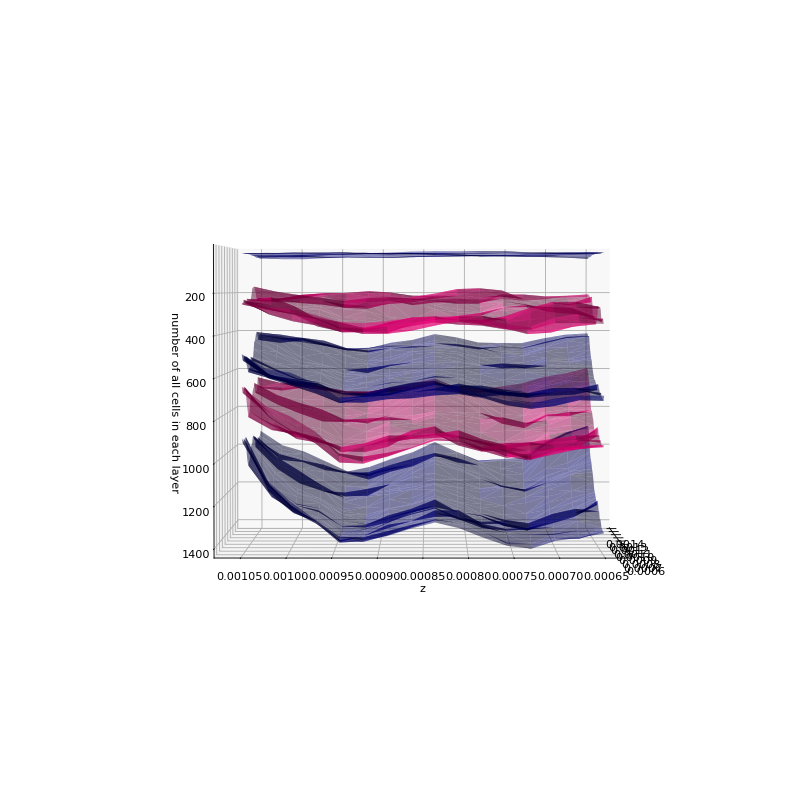

Text(0.5, 0, 'z')

In [20]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
for j in range(5):
    ax.plot_trisurf(centers[:, 0], centers[:, 2], np.array(cumul_num_cells[query_type])[:, j], color=(j % 2, 0, 0.5, 0.5))
ax.invert_zaxis()
ax.set_zlabel(f"number of {query_type} cells in each layer")
ax.set_xlabel("x")
ax.set_ylabel("z")

In [78]:
fig.savefig(f"laminarPopulationCount_{query_type}.svg")

<IPython.core.display.Javascript object>


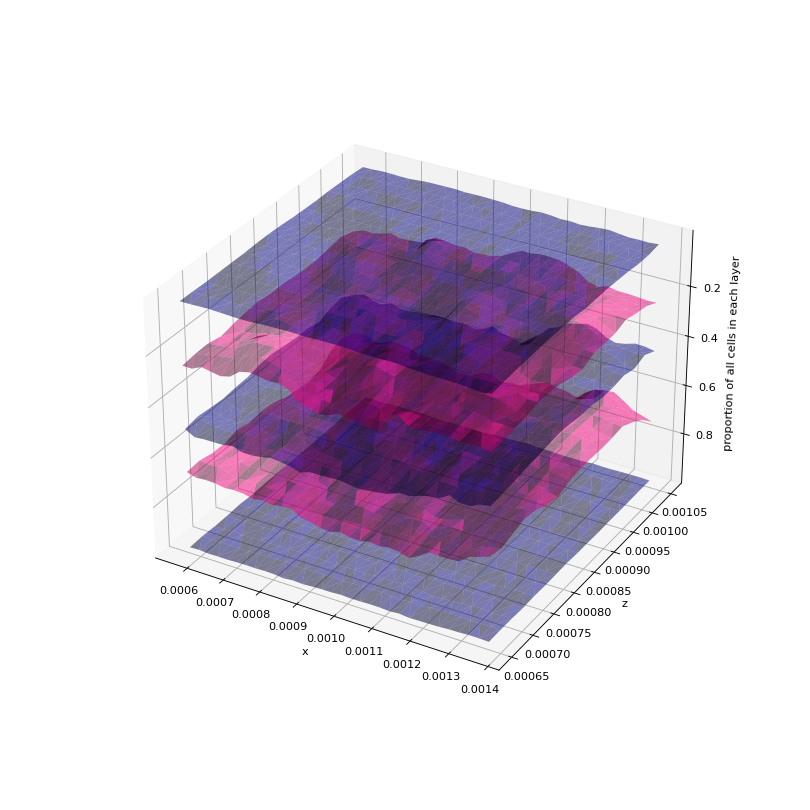

Text(0.5, 0, 'z')

In [26]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
for j in range(5):
    ax.plot_trisurf(centers[:, 0], centers[:, 2], cumul_num_cells[query_type][:, j] / cumul_num_cells[query_type][:, -1], color=(j % 2, 0, 0.5, 0.5))
ax.invert_zaxis()
ax.set_zlabel(f"proportion of {query_type} cells in each layer")
ax.set_xlabel("x")
ax.set_ylabel("z")

In [80]:
fig.savefig(f"laminarPopulationProportions_{query_type}.svg")

In [14]:
# with open("num_cells.json") as f:
#     num_cells_str = f.read()
#     num_cells = json.loads(num_cells_str)
    
# with open("cumul_num_cells.json") as f:
#     cumul_num_cells_str = f.read()
#     cumul_num_cells = json.loads(cumul_num_cells_str)

In [131]:
num_cells.keys(), cumul_num_cells.keys()

(dict_keys(['inh', '5P_IT', '5P_PT', '5P_NP', 'exc', 'BC', 'MC', 'BPC', 'NGC', 'all', 'neuron']),
 dict_keys(['inh', '5P_IT', '5P_PT', '5P_NP', 'exc', 'BC', 'MC', 'BPC', 'NGC', 'all', 'neuron']))

In [120]:
# cumul_num_cells = to_list_dict(cumul_num_cells)
# num_cells = to_list_dict(num_cells)
# with open("num_cells.json", "w") as f:
#     f.write(json.dumps(num_cells))
# with open("cumul_num_cells.json", "w") as f:
#     f.write(json.dumps(cumul_num_cells))

In [58]:
from nglui import statebuilder

In [55]:
ngl_cols = pred.cols_nm[256:272:4] / resolution

In [69]:
pd.concat?

In [70]:
links = []
col_cells = pd.DataFrame()
for i in range(4):
    col_cells = pd.concat([auto_cells[auto_cells.pt_position.apply(in_bbox, args=[ngl_cols[i]])].copy(), col_cells])

In [73]:
image_path = "precomputed://gs://iarpa_microns/minnie/minnie65/seg" #'precomputed://gs://microns_public_datasets/pinky100_v0/son_of_alignment_v15_rechunked'
segmentation_path = "precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em" #'precomputed://gs://microns_public_datasets/pinky100_v185/seg'

img = statebuilder.ImageLayerConfig(image_path)
seg = statebuilder.SegmentationLayerConfig(segmentation_path, selected_ids_column='pt_root_id')

points = statebuilder.PointMapper('pt_position', linked_segmentation_column='pt_root_id')
anno_layer = statebuilder.AnnotationLayerConfig('somas', mapping_rules=points, linked_segmentation_layer=seg.name)
sb = statebuilder.StateBuilder([img, seg, anno_layer])
sb.render_state(col_cells, return_as='html')

In [65]:
links[0]

In [66]:
links[1]

In [67]:
links[2]

In [68]:
links[3]

<IPython.core.display.HTML object>


i=0: [here](https://ngl.microns-explorer.org/#!%7B%22dimensions%22:%7B%22x%22:%5B4e-9%2C%22m%22%5D%2C%22y%22:%5B4e-9%2C%22m%22%5D%2C%22z%22:%5B4e-8%2C%22m%22%5D%7D%2C%22position%22:%5B272932.1875%2C205943.375%2C23696.740234375%5D%2C%22crossSectionScale%22:449.13536693135165%2C%22projectionOrientation%22:%5B0.26748326420783997%2C0.17458575963974%2C0.16309164464473724%2C-0.9334739446640015%5D%2C%22projectionScale%22:380533.98918011936%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%7B%22url%22:%22precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em%22%2C%22subsources%22:%7B%22default%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22tab%22:%22source%22%2C%22shaderControls%22:%7B%22normalized%22:%7B%22range%22:%5B86%2C172%5D%7D%7D%2C%22name%22:%22img65%22%7D%2C%7B%22type%22:%22image%22%2C%22source%22:%7B%22url%22:%22precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie35/em%22%2C%22subsources%22:%7B%22default%22:true%7D%2C%22enableDefaultSubsources%22:false%7D%2C%22tab%22:%22source%22%2C%22shaderControls%22:%7B%22normalized%22:%7B%22range%22:%5B112%2C172%5D%7D%7D%2C%22name%22:%22img35%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%22precomputed://gs://iarpa_microns/minnie/minnie65/seg%22%2C%22tab%22:%22segments%22%2C%22annotationColor%22:%22#8f8f8a%22%2C%22selectedAlpha%22:0.41%2C%22notSelectedAlpha%22:0.06%2C%22segments%22:%5B%22864691133654450645%22%2C%22864691134503934198%22%2C%22864691134645556499%22%2C%22864691134650720010%22%2C%22864691134784470212%22%2C%22864691134817893950%22%2C%22864691134829652312%22%2C%22864691134868783225%22%2C%22864691134884761082%22%2C%22864691134884763642%22%2C%22864691134884767226%22%2C%22864691134917402890%22%2C%22864691134917424138%22%2C%22864691134917430282%22%2C%22864691134917500426%22%2C%22864691134940014179%22%2C%22864691134947382268%22%2C%22864691134947410172%22%2C%22864691134947508988%22%2C%22864691134964466463%22%2C%22864691134964616735%22%2C%22864691134988406138%22%2C%22864691134988437114%22%2C%22864691134988446842%22%2C%22864691135012405494%22%2C%22864691135012405750%22%2C%22864691135012432118%22%2C%22864691135012436982%22%2C%22864691135012440054%22%2C%22864691135012440310%22%2C%22864691135012478198%22%2C%22864691135012514038%22%2C%22864691135012522998%22%2C%22864691135012794870%22%2C%22864691135012856726%22%2C%22864691135012874902%22%2C%22864691135012878486%22%2C%22864691135012878998%22%2C%22864691135012884886%22%2C%22864691135012889238%22%2C%22864691135012923542%22%2C%22864691135013188502%22%2C%22864691135058542235%22%2C%22864691135058572187%22%2C%22864691135058583451%22%2C%22864691135064984644%22%2C%22864691135064993092%22%2C%22864691135064997956%22%2C%22864691135065000260%22%2C%22864691135065038148%22%2C%22864691135065134148%22%2C%22864691135081639927%22%2C%22864691135081643255%22%2C%22864691135081644791%22%2C%22864691135081647863%22%2C%22864691135081683959%22%2C%22864691135081700855%22%2C%22864691135081751031%22%2C%22864691135081752055%22%2C%22864691135099857696%22%2C%22864691135103955021%22%2C%22864691135103958861%22%2C%22864691135103961165%22%2C%22864691135113151129%22%2C%22864691135113182873%22%2C%22864691135113204889%22%2C%22864691135117779677%22%2C%22864691135117782237%22%2C%22864691135117795805%22%2C%22864691135117807325%22%2C%22864691135122308135%22%2C%22864691135122312999%22%2C%22864691135122338343%22%2C%22864691135124939104%22%2C%22864691135132661408%22%2C%22864691135132663456%22%2C%22864691135132663968%22%2C%22864691135132674464%22%2C%22864691135134653721%22%2C%22864691135134688537%22%2C%22864691135134714649%22%2C%22864691135155570788%22%2C%22864691135155737188%22%2C%22864691135155826788%22%2C%22864691135162202413%22%2C%22864691135162221101%22%2C%22864691135162231853%22%2C%22864691135162277933%22%2C%22864691135172158568%22%2C%22864691135175393590%22%2C%22864691135181707266%22%2C%22864691135181714434%22%2C%22864691135181718530%22%2C%22864691135181721602%22%2C%22864691135181740546%22%2C%22864691135181745666%22%2C%22864691135181778690%22%2C%22864691135194409002%22%2C%22864691135194415402%22%2C%22864691135194423082%22%2C%22864691135194429738%22%2C%22864691135194431530%22%2C%22864691135194443562%22%2C%22864691135201693305%22%2C%22864691135207718265%22%2C%22864691135207719545%22%2C%22864691135207729529%22%2C%22864691135207730553%22%2C%22864691135207758457%22%2C%22864691135207780217%22%2C%22864691135207780985%22%2C%22864691135207784313%22%2C%22864691135207790713%22%2C%22864691135210016448%22%2C%22864691135211838803%22%2C%22864691135212611968%22%2C%22864691135212639872%22%2C%22864691135212707968%22%2C%22864691135212729984%22%2C%22864691135212959360%22%2C%22864691135213060152%22%2C%22864691135233099865%22%2C%22864691135233116761%22%2C%22864691135233135961%22%2C%22864691135241405008%22%2C%22864691135244035123%22%2C%22864691135256122543%22%2C%22864691135256149167%22%2C%22864691135269686181%22%2C%22864691135269698725%22%2C%22864691135269711525%22%2C%22864691135269724837%22%2C%22864691135269736869%22%2C%22864691135269766053%22%2C%22864691135269818533%22%2C%22864691135272154897%22%2C%22864691135272163345%22%2C%22864691135274068965%22%2C%22864691135274074341%22%2C%22864691135274122981%22%2C%22864691135274128869%22%2C%22864691135274129637%22%2C%22864691135274148581%22%2C%22864691135274149605%22%2C%22864691135291735478%22%2C%22864691135291776182%22%2C%22864691135291780278%22%2C%22864691135292722226%22%2C%22864691135293047564%22%2C%22864691135293061644%22%2C%22864691135293064460%22%2C%22864691135303174823%22%2C%22864691135303175079%22%2C%22864691135303189927%22%2C%22864691135303194535%22%2C%22864691135307124038%22%2C%22864691135322939548%22%2C%22864691135322952860%22%2C%22864691135322967124%22%2C%22864691135322983324%22%2C%22864691135334481897%22%2C%22864691135334483689%22%2C%22864691135334484457%22%2C%22864691135334484969%22%2C%22864691135334557161%22%2C%22864691135337693414%22%2C%22864691135337694182%22%2C%22864691135337712870%22%2C%22864691135340965317%22%2C%22864691135340972229%22%2C%22864691135340974277%22%2C%22864691135341023941%22%2C%22864691135341186993%22%2C%22864691135345108639%22%2C%22864691135345123743%22%2C%22864691135345157535%22%2C%22864691135345163679%22%2C%22864691135345166495%22%2C%22864691135345170591%22%2C%22864691135345170847%22%2C%22864691135345240735%22%2C%22864691135345249695%22%2C%22864691135345264031%22%2C%22864691135345266847%22%2C%22864691135345267615%22%2C%22864691135345273503%22%2C%22864691135348256471%22%2C%22864691135348276951%22%2C%22864691135348495831%22%2C%22864691135354939599%22%2C%22864691135354964943%22%2C%22864691135355069391%22%2C%22864691135358337255%22%2C%22864691135358808152%22%2C%22864691135358828376%22%2C%22864691135358830168%22%2C%22864691135358831448%22%2C%22864691135360115527%22%2C%22864691135360116295%22%2C%22864691135360118087%22%2C%22864691135360127047%22%2C%22864691135360133447%22%2C%22864691135360156743%22%2C%22864691135360175431%22%2C%22864691135367002105%22%2C%22864691135367002617%22%2C%22864691135367020793%22%2C%22864691135367179513%22%2C%22864691135367317497%22%2C%22864691135373382856%22%2C%22864691135373385928%22%2C%22864691135373394888%22%2C%22864691135373404616%22%2C%22864691135373415624%22%2C%22864691135373444040%22%2C%22864691135373640009%22%2C%22864691135373674184%22%2C%22864691135373684553%22%2C%22864691135373685321%22%2C%22864691135373698633%22%2C%22864691135373717065%22%2C%22864691135380335899%22%2C%22864691135382462938%22%2C%22864691135382479578%22%2C%22864691135382509530%22%2C%22864691135382688730%22%2C%22864691135382921195%22%2C%22864691135382927595%22%2C%22864691135382964715%22%2C%22864691135382973931%22%2C%22864691135385214805%22%2C%22864691135385226837%22%2C%22864691135385242965%22%2C%22864691135385306197%22%2C%22864691135385320021%22%2C%22864691135385321045%22%2C%22864691135385361749%22%2C%22864691135385393589%22%2C%22864691135385702581%22%2C%22864691135386376833%22%2C%22864691135386377857%22%2C%22864691135386396033%22%2C%22864691135387581682%22%2C%22864691135392041202%22%2C%22864691135392097461%22%2C%22864691135393975541%22%2C%22864691135394008309%22%2C%22864691135394015477%22%2C%22864691135394208501%22%2C%22864691135396382241%22%2C%22864691135396384033%22%2C%22864691135396388641%22%2C%22864691135396389153%22%2C%22864691135396399137%22%2C%22864691135403724270%22%2C%22864691135403761134%22%2C%22864691135403791854%22%2C%22864691135403913966%22%2C%22864691135407310793%22%2C%22864691135407326921%22%2C%22864691135407328713%22%2C%22864691135407332297%22%2C%22864691135415471546%22%2C%22864691135415474618%22%2C%22864691135415485621%22%2C%22864691135420034485%22%2C%22864691135420564199%22%2C%22864691135422419381%22%2C%22864691135422992309%22%2C%22864691135425455285%22%2C%22864691135428490800%22%2C%22864691135428506928%22%2C%22864691135428510000%22%2C%22864691135428514352%22%2C%22864691135429912562%22%2C%22864691135439433458%22%2C%22864691135440495176%22%2C%22864691135440506440%22%2C%22864691135440512328%22%2C%22864691135440565576%22%2C%22864691135445560978%22%2C%22864691135445632658%22%2C%22864691135445640338%22%2C%22864691135446563902%22%2C%22864691135446613844%22%2C%22864691135448562884%22%2C%22864691135449401150%22%2C%22864691135453318023%22%2C%22864691135454045546%22%2C%22864691135454053994%22%2C%22864691135454056042%22%2C%22864691135454091370%22%2C%22864691135454102378%22%2C%22864691135454106730%22%2C%22864691135462241693%22%2C%22864691135462691902%22%2C%22864691135462698046%22%2C%22864691135462755902%22%2C%22864691135462773310%22%2C%22864691135462781758%22%2C%22864691135462784830%22%2C%22864691135463496773%22%2C%22864691135463500101%22%2C%22864691135463522629%22%2C%22864691135463638853%22%2C%22864691135465686965%22%2C%22864691135467539084%22%2C%22864691135467539852%22%2C%22864691135467569292%22%2C%22864691135467572620%22%2C%22864691135467593356%22%2C%22864691135467899378%22%2C%22864691135468156754%22%2C%22864691135468167506%22%2C%22864691135468292946%22%2C%22864691135468362578%22%2C%22864691135471376821%22%2C%22864691135472027442%22%2C%22864691135472028722%22%2C%22864691135472031282%22%2C%22864691135472746482%22%2C%22864691135473042162%22%2C%22864691135474609216%22%2C%22864691135474616128%22%2C%22864691135474618432%22%2C%22864691135474618688%22%2C%22864691135474642240%22%2C%22864691135474665024%22%2C%22864691135474763328%22%2C%22864691135476118184%22%2C%22864691135476138664%22%2C%22864691135476165032%22%2C%22864691135476677187%22%2C%22864691135478268870%22%2C%22864691135478281158%22%2C%22864691135478289350%22%2C%22864691135485771701%22%2C%22864691135487471029%22%2C%22864691135488230714%22%2C%22864691135488232250%22%2C%22864691135488274234%22%2C%22864691135488278842%22%2C%22864691135488280634%22%2C%22864691135490228071%22%2C%22864691135490265842%22%2C%22864691135490614759%22%2C%22864691135490843367%22%2C%22864691135491219039%22%2C%22864691135491250271%22%2C%22864691135491840498%22%2C%22864691135491845874%22%2C%22864691135492783346%22%2C%22864691135493370354%22%2C%22864691135493971344%22%2C%22864691135494002418%22%2C%22864691135494526756%22%2C%22864691135495957941%22%2C%22864691135497083634%22%2C%22864691135497617683%22%2C%22864691135497620755%22%2C%22864691135497622291%22%2C%22864691135497634323%22%2C%22864691135497645331%22%2C%22864691135501082308%22%2C%22864691135501538370%22%2C%22864691135501549890%22%2C%22864691135501562946%22%2C%22864691135501563458%22%2C%22864691135501572418%22%2C%22864691135501597250%22%2C%22864691135501603906%22%2C%22864691135501772610%22%2C%22864691135501854045%22%2C%22864691135502019253%22%2C%22864691135502051509%22%2C%22864691135502052277%22%2C%22864691135502077877%22%2C%22864691135502904562%22%2C%22864691135504473330%22%2C%22864691135504588786%22%2C%22864691135506652658%22%2C%22864691135508696585%22%2C%22864691135508814601%22%2C%22864691135508871433%22%2C%22864691135508925449%22%2C%22864691135510414032%22%2C%22864691135510419152%22%2C%22864691135510484432%22%2C%22864691135510498000%22%2C%22864691135510500304%22%2C%22864691135510507728%22%2C%22864691135510510544%22%2C%22864691135510511568%22%2C%22864691135515224818%22%2C%22864691135515927251%22%2C%22864691135517343370%22%2C%22864691135517356170%22%2C%22864691135523225586%22%2C%22864691135524649458%22%2C%22864691135526047323%22%2C%22864691135526088283%22%2C%22864691135527487986%22%2C%22864691135527934962%22%2C%22864691135533833156%22%2C%22864691135533835460%22%2C%22864691135538127474%22%2C%22864691135538141810%22%2C%22864691135538151026%22%2C%22864691135544371496%22%2C%22864691135544393000%22%2C%22864691135544411432%22%2C%22864691135544436776%22%2C%22864691135547114180%22%2C%22864691135550095602%22%2C%22864691135560517601%22%2C%22864691135560521697%22%2C%22864691135560525025%22%2C%22864691135560711649%22%2C%22864691135562499524%22%2C%22864691135564544791%22%2C%22864691135564548887%22%2C%22864691135564667735%22%2C%22864691135564680535%22%2C%22864691135564699479%22%2C%22864691135564699735%22%2C%22864691135564827735%22%2C%22864691135567761644%22%2C%22864691135568873350%22%2C%22864691135568894086%22%2C%22864691135568900230%22%2C%22864691135568926854%22%2C%22864691135568928646%22%2C%22864691135570652653%22%2C%22864691135570690541%22%2C%22864691135570703341%22%2C%22864691135570708205%22%2C%22864691135570731501%22%2C%22864691135570737901%22%2C%22864691135570741229%22%2C%22864691135570743789%22%2C%22864691135571214066%22%2C%22864691135571216933%22%2C%22864691135571218469%22%2C%22864691135571246373%22%2C%22864691135571253797%22%2C%22864691135571256869%22%2C%22864691135571265829%22%2C%22864691135571280421%22%2C%22864691135572013042%22%2C%22864691135572059634%22%2C%22864691135574061731%22%2C%22864691135575093278%22%2C%22864691135575100446%22%2C%22864691135575125790%22%2C%22864691135576941573%22%2C%22864691135576961285%22%2C%22864691135577008133%22%2C%22864691135577024773%22%2C%22864691135577033221%22%2C%22864691135577033733%22%2C%22864691135577035269%22%2C%22864691135577036037%22%2C%22864691135578559299%22%2C%22864691135580503619%22%2C%22864691135580553027%22%2C%22864691135581239363%22%2C%22864691135581570413%22%2C%22864691135581593709%22%2C%22864691135581610093%22%2C%22864691135581831533%22%2C%22864691135582229234%22%2C%22864691135582233586%22%2C%22864691135582370802%22%2C%22864691135583297347%22%2C%22864691135583320899%22%2C%22864691135583342403%22%2C%22864691135583342915%22%2C%22864691135583617522%22%2C%22864691135583689592%22%2C%22864691135583718776%22%2C%22864691135583957490%22%2C%22864691135583985731%22%2C%22864691135584032067%22%2C%22864691135584066371%22%2C%22864691135584070898%22%2C%22864691135584186098%22%2C%22864691135584235506%22%2C%22864691135584245234%22%2C%22864691135584247282%22%2C%22864691135584334066%22%2C%22864691135584427762%22%2C%22864691135584476402%22%2C%22864691135585089778%22%2C%22864691135585112387%22%2C%22864691135585128316%22%2C%22864691135585131132%22%2C%22864691135585133692%22%2C%22864691135585386051%22%2C%22864691135585748803%22%2C%22864691135586087747%22%2C%22864691135586259954%22%2C%22864691135586561603%22%2C%22864691135586866162%22%2C%22864691135586911986%22%2C%22864691135586950642%22%2C%22864691135586956018%22%2C%22864691135586980850%22%2C%22864691135587028466%22%2C%22864691135587120626%22%2C%22864691135587715139%22%2C%22864691135588445170%22%2C%22864691135588483139%22%2C%22864691135589144050%22%2C%22864691135589215986%22%2C%22864691135589892619%22%2C%22864691135589957643%22%2C%22864691135593528875%22%2C%22864691135593539627%22%2C%22864691135593548843%22%2C%22864691135593559083%22%2C%22864691135593619908%22%2C%22864691135595976003%22%2C%22864691135597942339%22%2C%22864691135599315267%22%2C%22864691135599318595%22%2C%22864691135599320387%22%2C%22864691135599329859%22%2C%22864691135599349827%22%2C%22864691135599625283%22%2C%22864691135599815747%22%2C%22864691135599938883%22%2C%22864691135600208451%22%2C%22864691135600244803%22%2C%22864691135600256835%22%2C%22864691135601142851%22%2C%22864691135601265731%22%2C%22864691135601359427%22%2C%22864691135601451843%22%2C%22864691135601499715%22%2C%22864691135601500995%22%2C%22864691135602352963%22%2C%22864691135602603716%22%2C%22864691135602992195%22%2C%22864691135602992963%22%2C%22864691135603299395%22%2C%22864691135603339843%22%2C%22864691135603379523%22%2C%22864691135603392835%22%2C%22864691135603857987%22%2C%22864691135604515139%22%2C%22864691135604518979%22%2C%22864691135606482755%22%2C%22864691135608749123%22%2C%22864691135610232899%22%2C%22864691135613116227%22%2C%22864691135614137035%22%2C%22864691135614168779%22%2C%22864691135614172107%22%2C%22864691135614255556%22%2C%22864691135615876163%22%2C%22864691135616107369%22%2C%22864691135617735823%22%2C%22864691135617746063%22%2C%22864691135617756303%22%2C%22864691135617781059%22%2C%22864691135617798031%22%2C%22864691135617803919%22%2C%22864691135617805199%22%2C%22864691135626318915%22%2C%22864691135628287684%22%2C%22864691135630685892%22%2C%22864691135630716868%22%2C%22864691135631799492%22%2C%22864691135632332355%22%2C%22864691135633463363%22%2C%22864691135633911492%22%2C%22864691135637832388%22%2C%22864691135638976315%22%2C%22864691135638995771%22%2C%22864691135639161540%22%2C%22864691135640985028%22%2C%22864691135641229508%22%2C%22864691135641814083%22%2C%22864691135643516227%22%2C%22864691135644585967%22%2C%22864691135644589295%22%2C%22864691135644594671%22%2C%22864691135644610543%22%2C%22864691135644647407%22%2C%22864691135644648175%22%2C%22864691135644657135%22%2C%22864691135644662767%22%2C%22864691135644700143%22%2C%22864691135644701935%22%2C%22864691135653612484%22%2C%22864691135654045378%22%2C%22864691135654051778%22%2C%22864691135654120642%22%2C%22864691135657790338%22%2C%22864691135657793666%22%2C%22864691135657808002%22%2C%22864691135657829762%22%2C%22864691135660513264%22%2C%22864691135665942468%22%2C%22864691135665949124%22%2C%22864691135669708099%22%2C%22864691135674458564%22%2C%22864691135678028228%22%2C%22864691135679666884%22%2C%22864691135681225668%22%2C%22864691135681236420%22%2C%22864691135681281220%22%2C%22864691135681417412%22%2C%22864691135681710276%22%2C%22864691135683080900%22%2C%22864691135683245810%22%2C%22864691135683942327%22%2C%22864691135683951799%22%2C%22864691135686893792%22%2C%22864691135686922464%22%2C%22864691135686952160%22%2C%22864691135692724159%22%2C%22864691135692727743%22%2C%22864691135692754367%22%2C%22864691135692756927%22%2C%22864691135692759487%22%2C%22864691135692761279%22%2C%22864691135696160922%22%2C%22864691135697359381%22%2C%22864691135697372437%22%2C%22864691135697378837%22%2C%22864691135697379093%22%2C%22864691135697409045%22%2C%22864691135699267106%22%2C%22864691135699291938%22%2C%22864691135700229499%22%2C%22864691135700249467%22%2C%22864691135700444027%22%2C%22864691135700484987%22%2C%22864691135715903124%22%2C%22864691135718448945%22%2C%22864691135718463281%22%2C%22864691135724211371%22%2C%22864691135724215211%22%2C%22864691135724216747%22%2C%22864691135724229547%22%2C%22864691135725609535%22%2C%22864691135725612607%22%2C%22864691135725631039%22%2C%22864691135725640511%22%2C%22864691135725644095%22%2C%22864691135725656127%22%2C%22864691135730128313%22%2C%22864691135730129337%22%2C%22864691135730129593%22%2C%22864691135730164409%22%2C%22864691135730165689%22%2C%22864691135730325945%22%2C%22864691135736880772%22%2C%22864691135737499249%22%2C%22864691135737501809%22%2C%22864691135739565204%22%2C%22864691135739593876%22%2C%22864691135740204395%22%2C%22864691135740205419%22%2C%22864691135740252011%22%2C%22864691135746106760%22%2C%22864691135746236296%22%2C%22864691135746328968%22%2C%22864691135746567560%22%2C%22864691135748598825%22%2C%22864691135748599849%22%2C%22864691135749453448%22%2C%22864691135750158472%22%2C%22864691135750649224%22%2C%22864691135750650760%22%2C%22864691135750711944%22%2C%22864691135750723208%22%2C%22864691135750733960%22%2C%22864691135751179144%22%2C%22864691135751184776%22%2C%22864691135751202184%22%2C%22864691135751212936%22%2C%22864691135751234440%22%2C%22864691135751278472%22%2C%22864691135751358344%22%2C%22864691135751392392%22%2C%22864691135751407496%22%2C%22864691135751563400%22%2C%22864691135751603848%22%2C%22864691135751635848%22%2C%22864691135751675528%22%2C%22864691135751792776%22%2C%22864691135751804040%22%2C%22864691135751809672%22%2C%22864691135751870600%22%2C%22864691135753574349%22%2C%22864691135753584589%22%2C%22864691135753598413%22%2C%22864691135753683661%22%2C%22864691135753703629%22%2C%22864691135753703885%22%2C%22864691135753729997%22%2C%22864691135753733069%22%2C%22864691135753738445%22%2C%22864691135753739981%22%2C%22864691135753754573%22%2C%22864691135758468686%22%2C%22864691135758481998%22%2C%22864691135758518862%22%2C%22864691135758522958%22%2C%22864691135758563918%22%2C%22864691135758564430%22%2C%22864691135761522486%22%2C%22864691135761552694%22%2C%22864691135761805366%22%2C%22864691135771611643%22%2C%22864691135771713099%22%2C%22864691135771723339%22%2C%22864691135771734859%22%2C%22864691135771945723%22%2C%22864691135775797933%22%2C%22864691135775798445%22%2C%22864691135775808429%22%2C%22864691135775810221%22%2C%22864691135775815341%22%2C%22864691135775821997%22%2C%22864691135776545120%22%2C%22864691135776555104%22%2C%22864691135776579168%22%2C%22864691135776671328%22%2C%22864691135776671584%22%2C%22864691135776671840%22%2C%22864691135776674656%22%2C%22864691135777115325%22%2C%22864691135777120189%22%2C%22864691135777122493%22%2C%22864691135777147325%22%2C%22864691135777149117%22%2C%22864691135777163965%22%2C%22864691135780785744%22%2C%22864691135780822096%22%2C%22864691135782388787%22%2C%22864691135782410035%22%2C%22864691135782414899%22%2C%22864691135782416947%22%2C%22864691135782427187%22%2C%22864691135782432307%22%2C%22864691135782449203%22%2C%22864691135785265348%22%2C%22864691135785270212%22%2C%22864691135785341636%22%2C%22864691135799757666%22%2C%22864691135799776866%22%2C%22864691135799944802%22%2C%22864691135807198493%22%2C%22864691135807258909%22%2C%22864691135807263773%22%2C%22864691135807337757%22%2C%22864691135807348765%22%2C%22864691135809434828%22%2C%22864691135809442508%22%2C%22864691135809482956%22%2C%22864691135809529292%22%2C%22864691135821225853%22%2C%22864691135826609628%22%2C%22864691135837191059%22%2C%22864691135837205907%22%2C%22864691135841052643%22%2C%22864691135841225699%22%2C%22864691135843248399%22%2C%22864691135843574031%22%2C%22864691135847917662%22%2C%22864691135847922270%22%2C%22864691135847925598%22%2C%22864691135847935070%22%2C%22864691135850652103%22%2C%22864691135850744263%22%2C%22864691135855571502%22%2C%22864691135855593262%22%2C%22864691135855688238%22%2C%22864691135858688104%22%2C%22864691135858693992%22%2C%22864691135858700136%22%2C%22864691135864062590%22%2C%22864691135864068990%22%2C%22864691135864070782%22%2C%22864691135864071038%22%2C%22864691135864080510%22%2C%22864691135864533631%22%2C%22864691135864676316%22%2C%22864691135864680668%22%2C%22864691135864681436%22%2C%22864691135864692188%22%2C%22864691135864747484%22%2C%22864691135865494405%22%2C%22864691135865513605%22%2C%22864691135865548933%22%2C%22864691135865584773%22%2C%22864691135865609349%22%2C%22864691135866375702%22%2C%22864691135866386710%22%2C%22864691135866403606%22%2C%22864691135866421782%22%2C%22864691135873605518%22%2C%22864691135873612686%22%2C%22864691135874194529%22%2C%22864691135875963731%22%2C%22864691135876007251%22%2C%22864691135876021587%22%2C%22864691135876027475%22%2C%22864691135876029267%22%2C%22864691135876155731%22%2C%22864691135876173139%22%2C%22864691135883867248%22%2C%22864691135883885168%22%2C%22864691135883901808%22%2C%22864691135884077168%22%2C%22864691135888466569%22%2C%22864691135888484745%22%2C%22864691135888508297%22%2C%22864691135888534921%22%2C%22864691135892937599%22%2C%22864691135899532897%22%2C%22864691135901150561%22%2C%22864691135906962017%22%2C%22864691135909751465%22%2C%22864691135909759913%22%2C%22864691135910874465%22%2C%22864691135911102305%22%2C%22864691135911741281%22%2C%22864691135915177318%22%2C%22864691135915181158%22%2C%22864691135915183206%22%2C%22864691135915192934%22%2C%22864691135915379558%22%2C%22864691135917687649%22%2C%22864691135918322096%22%2C%22864691135918324656%22%2C%22864691135918329008%22%2C%22864691135919615841%22%2C%22864691135919697249%22%2C%22864691135921436769%22%2C%22864691135925509390%22%2C%22864691135925571086%22%2C%22864691135926315732%22%2C%22864691135926326228%22%2C%22864691135926520788%22%2C%22864691135927451233%22%2C%22864691135937222660%22%2C%22864691135937222916%22%2C%22864691135937343285%22%2C%22864691135937388597%22%2C%22864691135937410357%22%2C%22864691135939285249%22%2C%22864691135939301377%22%2C%22864691135939310337%22%2C%22864691135939311105%22%2C%22864691135939312129%22%2C%22864691135939341057%22%2C%22864691135939353089%22%2C%22864691135939359233%22%2C%22864691135939368961%22%2C%22864691135939408385%22%2C%22864691135939420417%22%2C%22864691135939425025%22%2C%22864691135939435777%22%2C%22864691135939637158%22%2C%22864691135939647398%22%2C%22864691135939679910%22%2C%22864691135941112948%22%2C%22864691135941141108%22%2C%22864691135941142388%22%2C%22864691135941191540%22%2C%22864691135941196148%22%2C%22864691135945394212%22%2C%22864691135945448484%22%2C%22864691135945484324%22%2C%22864691135945560612%22%2C%22864691135945561636%22%2C%22864691135946637153%22%2C%22864691135946637921%22%2C%22864691135946643553%22%2C%22864691135946643809%22%2C%22864691135946680161%22%2C%22864691135946680417%22%2C%22864691135946698849%22%2C%22864691135946742369%22%2C%22864691135946885729%22%2C%22864691135947203274%22%2C%22864691135951971363%22%2C%22864691135951983651%22%2C%22864691135952019747%22%2C%22864691135953759752%22%2C%22864691135953762568%22%2C%22864691135953769480%22%2C%22864691135953842184%22%2C%22864691135968884581%22%2C%22864691135968893797%22%2C%22864691135968900453%22%2C%22864691135968940901%22%2C%22864691135974433647%22%2C%22864691135974444143%22%2C%22864691135974465135%22%2C%22864691135975477571%22%2C%22864691135975496003%22%2C%22864691135979537544%22%2C%22864691135980296328%22%2C%22864691135980297352%22%2C%22864691135980365192%22%2C%22864691135981505160%22%2C%22864691135987758984%22%2C%22864691135987768456%22%2C%22864691135987774344%22%2C%22864691135987979912%22%2C%22864691135988007304%22%2C%22864691135991161224%22%2C%22864691135991317640%22%2C%22864691135991486145%22%2C%22864691135991525825%22%2C%22864691135991945864%22%2C%22864691135994572970%22%2C%22864691135999858312%22%2C%22864691136000612232%22%2C%22864691136002290056%22%2C%22864691136003567496%22%2C%22864691136004989898%22%2C%22864691136008401580%22%2C%22864691136008406956%22%2C%22864691136008407724%22%2C%22864691136008410504%22%2C%22864691136008418476%22%2C%22864691136008446892%22%2C%22864691136008464044%22%2C%22864691136008488108%22%2C%22864691136008499628%22%2C%22864691136008511660%22%2C%22864691136008518060%22%2C%22864691136008543150%22%2C%22864691136008562350%22%2C%22864691136008562606%22%2C%22864691136008566190%22%2C%22864691136008671148%22%2C%22864691136008786606%22%2C%22864691136010885539%22%2C%22864691136010900131%22%2C%22864691136010920355%22%2C%22864691136010936483%22%2C%22864691136010969763%22%2C%22864691136010978723%22%2C%22864691136017576328%22%2C%22864691136017850504%22%2C%22864691136020234232%22%2C%22864691136020238840%22%2C%22864691136020239864%22%2C%22864691136020240888%22%2C%22864691136020268792%22%2C%22864691136020274168%22%2C%22864691136020278008%22%2C%22864691136020319736%22%2C%22864691136020321016%22%2C%22864691136020328696%22%2C%22864691136022270856%22%2C%22864691136022284168%22%2C%22864691136023057800%22%2C%22864691136023237512%22%2C%22864691136023254664%22%2C%22864691136023723577%22%2C%22864691136023744569%22%2C%22864691136023795769%22%2C%22864691136023796025%22%2C%22864691136023796537%22%2C%22864691136023837497%22%2C%22864691136029948808%22%2C%22864691136030188936%22%2C%22864691136031661243%22%2C%22864691136031663291%22%2C%22864691136031671995%22%2C%22864691136031773883%22%2C%22864691136031788731%22%2C%22864691136031928251%22%2C%22864691136039373822%22%2C%22864691136039377918%22%2C%22864691136039380734%22%2C%22864691136039405566%22%2C%22864691136039410686%22%2C%22864691136039413502%22%2C%22864691136040991318%22%2C%22864691136040996950%22%2C%22864691136040999586%22%2C%22864691136041015894%22%2C%22864691136041017942%22%2C%22864691136041041494%22%2C%22864691136041084502%22%2C%22864691136041088598%22%2C%22864691136042104456%22%2C%22864691136042526344%22%2C%22864691136042823048%22%2C%22864691136043523976%22%2C%22864691136044089992%22%2C%22864691136045819528%22%2C%22864691136047897250%22%2C%22864691136050825203%22%2C%22864691136050832371%22%2C%22864691136050837491%22%2C%22864691136050841075%22%2C%22864691136050880755%22%2C%22864691136056361176%22%2C%22864691136056404696%22%2C%22864691136056644568%22%2C%22864691136065221528%22%2C%22864691136065227928%22%2C%22864691136065235352%22%2C%22864691136065260184%22%2C%22864691136065273496%22%2C%22864691136065295768%22%2C%22864691136084061548%22%2C%22864691136084089196%22%2C%22864691136084214380%22%2C%22864691136088936247%22%2C%22864691136088946999%22%2C%22864691136088973879%22%2C%22864691136090912436%22%2C%22864691136090925748%22%2C%22864691136090926516%22%2C%22864691136090933172%22%2C%22864691136093706102%22%2C%22864691136099763829%22%2C%22864691136099828085%22%2C%22864691136105454041%22%2C%22864691136108714936%22%2C%22864691136108746936%22%2C%22864691136108747448%22%2C%22864691136108837048%22%2C%22864691136109032120%22%2C%22864691136116156580%22%2C%22864691136116160420%22%2C%22864691136116194980%22%2C%22864691136118419480%22%2C%22864691136118427672%22%2C%22864691136118431256%22%2C%22864691136118434072%22%2C%22864691136118436376%22%2C%22864691136118447384%22%2C%22864691136118458392%22%2C%22864691136118928776%22%2C%22864691136123694118%22%2C%22864691136123699238%22%2C%22864691136123705382%22%2C%22864691136123712038%22%2C%22864691136123740710%22%2C%22864691136123796006%22%2C%22864691136134431371%22%2C%22864691136136778877%22%2C%22864691136143354164%22%2C%22864691136143399988%22%2C%22864691136143420468%22%2C%22864691136143566388%22%2C%22864691136175022598%22%2C%22864691136175076614%22%2C%22864691136175081734%22%2C%22864691136177078998%22%2C%22864691136194028758%22%2C%22864691136194058454%22%2C%22864691136194068182%22%2C%22864691136194175208%22%2C%22864691136194185192%22%2C%22864691136194215912%22%2C%22864691136194220008%22%2C%22864691136209030076%22%2C%22864691136218406492%22%2C%22864691136226966353%22%2C%22864691136226990929%22%2C%22864691136236656911%22%2C%22864691136236678415%22%2C%22864691136236693007%22%2C%22864691136236714767%22%2C%22864691136236716559%22%2C%22864691136236722703%22%2C%22864691136236748815%22%2C%22864691136236904719%22%2C%22864691136237472316%22%2C%22864691136237474620%22%2C%22864691136237528124%22%2C%22864691136266426612%22%2C%22864691136267696286%22%2C%22864691136272922302%22%2C%22864691136272978622%22%2C%22864691136272992702%22%2C%22864691136273014718%22%2C%22864691136273015486%22%2C%22864691136273019326%22%2C%22864691136273624589%22%2C%22864691136286557379%22%2C%22864691136286603715%22%2C%22864691136296667675%22%2C%22864691136296669467%22%2C%22864691136296710427%22%2C%22864691136296743963%22%2C%22864691136296744219%22%2C%22864691136309642330%22%2C%22864691136309643866%22%2C%22864691136309657946%22%2C%22864691136309700698%22%2C%22864691136309701466%22%2C%22864691136309812826%22%2C%22864691136309856346%22%2C%22864691136311742013%22%2C%22864691136311767869%22%2C%22864691136311843389%22%2C%22864691136311953725%22%2C%22864691136333759411%22%2C%22864691136333820595%22%2C%22864691136333969843%22%2C%22864691136361495010%22%2C%22864691136361501666%22%2C%22864691136361504226%22%2C%22864691136361519586%22%2C%22864691136370788488%22%2C%22864691136370822024%22%2C%22864691136370829192%22%2C%22864691136378766549%22%2C%22864691136378772693%22%2C%22864691136378777813%22%2C%22864691136378991573%22%2C%22864691136388599568%22%2C%22864691136390395775%22%2C%22864691136390428799%22%2C%22864691136390435455%22%2C%22864691136418648471%22%2C%22864691136418655383%22%2C%22864691136422866223%22%2C%22864691136433266078%22%2C%22864691136436392350%22%2C%22864691136436410526%22%2C%22864691136436416926%22%2C%22864691136436616606%22%2C%22864691136436919926%22%2C%22864691136437025654%22%2C%22864691136438273142%22%2C%22864691136443719299%22%2C%22864691136443732099%22%2C%22864691136443758211%22%2C%22864691136451083519%22%2C%22864691136451111679%22%2C%22864691136482869804%22%2C%22864691136482880044%22%2C%22864691136482912556%22%2C%22864691136486769426%22%2C%22864691136486771986%22%2C%22864691136486805010%22%2C%22864691136521578385%22%2C%22864691136543840718%22%2C%22864691136577472276%22%2C%22864691136577473044%22%2C%22864691136577484052%22%2C%22864691136577489428%22%2C%22864691136586904469%22%2C%22864691136587814774%22%2C%22864691136587818614%22%2C%22864691136588144502%22%2C%22864691136589556598%22%2C%22864691136594502306%22%2C%22864691136601558481%22%2C%22864691136601558737%22%2C%22864691136601560017%22%2C%22864691136601576401%22%2C%22864691136601588945%22%2C%22864691136617116123%22%2C%22864691136617145051%22%2C%22864691136617146587%22%2C%22864691136618394765%22%2C%22864691136618404493%22%2C%22864691136618409869%22%2C%22864691136618425741%22%2C%22864691136618439053%22%2C%22864691136618502541%22%2C%22864691136662174430%22%2C%22864691136662221278%22%2C%22864691136662223326%22%2C%22864691136662232542%22%2C%22864691136672639623%22%2C%22864691136672693895%22%2C%22864691136681503772%22%2C%22864691136681794422%22%2C%22864691136682123126%22%2C%22864691136683211126%22%2C%22864691136683855990%22%2C%22864691136684022390%22%2C%22864691136691570806%22%2C%22864691136691601782%22%2C%22864691136691704438%22%2C%22864691136691800182%22%2C%22864691136691822198%22%2C%22864691136692240246%22%2C%22864691136692263030%22%2C%22864691136692707958%22%2C%22864691136692713590%22%2C%22864691136692737398%22%2C%22864691136693051254%22%2C%22864691136693057910%22%2C%22864691136693086838%22%2C%22864691136693275766%22%2C%22864691136695988086%22%2C%22864691136702142574%22%2C%22864691136708588918%22%2C%22864691136711520630%22%2C%22864691136711928950%22%2C%22864691136720072054%22%2C%22864691136720077686%22%2C%22864691136723305213%22%2C%22864691136723320573%22%2C%22864691136723326973%22%2C%22864691136723329021%22%2C%22864691136723351293%22%2C%22864691136723358973%22%2C%22864691136723436541%22%2C%22864691136723440637%22%2C%22864691136723457789%22%2C%22864691136723474429%22%2C%22864691136723478013%22%2C%22864691136723480061%22%2C%22864691136723485693%22%2C%22864691136723565821%22%2C%22864691136723576061%22%2C%22864691136723579901%22%2C%22864691136723583997%22%2C%22864691136723585533%22%2C%22864691136729431670%22%2C%22864691136731260278%22%2C%22864691136731263862%22%2C%22864691136731355766%22%2C%22864691136732356982%22%2C%22864691136732839030%22%2C%22864691136734517878%22%2C%22864691136736851062%22%2C%22864691136740430172%22%2C%22864691136740446556%22%2C%22864691136776832622%22%2C%22864691136811794803%22%2C%22864691136811805555%22%2C%22864691136811831411%22%2C%22864691136839137134%22%2C%22864691136849661294%22%2C%22864691136864636270%22%2C%22864691136864700270%22%2C%22864691136864744302%22%2C%22864691136865011566%22%2C%22864691136865593966%22%2C%22864691136866493806%22%2C%22864691136866952558%22%2C%22864691136867573102%22%2C%22864691136868075374%22%2C%22864691136871213422%22%2C%22864691136873765998%22%2C%22864691136873833070%22%2C%22864691136874923118%22%2C%22864691136877730414%22%2C%22864691136879760238%22%2C%22864691136881813614%22%2C%22864691136882049646%22%2C%22864691136882086254%22%2C%22864691136882831214%22%2C%22864691136883658350%22%2C%22864691136884005742%22%2C%22864691136888702574%22%2C%22864691136892883310%22%2C%22864691136895226222%22%2C%22864691136895735918%22%2C%22864691136895806830%22%2C%22864691136898656366%22%2C%22864691136900538222%22%2C%22864691136900640366%22%2C%22864691136900804206%22%2C%22864691136901200494%22%2C%22864691136903024818%22%2C%22864691136903050418%22%2C%22864691136903050674%22%2C%22864691136905922158%22%2C%22864691136906317422%22%2C%22864691136906559086%22%2C%22864691136906562414%22%2C%22864691136906591342%22%2C%22864691136906613358%22%2C%22864691136906636910%22%2C%22864691136906675310%22%2C%22864691136906675822%22%2C%22864691136906710894%22%2C%22864691136906714478%22%2C%22864691136906752878%22%2C%22864691136906761838%22%2C%22864691136906798702%22%2C%22864691136906798958%22%2C%22864691136906806382%22%2C%22864691136906920302%22%2C%22864691136906979694%22%2C%22864691136906988654%22%2C%22864691136907516526%22%2C%22864691136908969070%22%2C%22864691136909366382%22%2C%22864691136911640049%22%2C%22864691136911644401%22%2C%22864691136911900145%22%2C%22864691136912488302%22%2C%22864691136913415534%22%2C%22864691136913596270%22%2C%22864691136914647662%22%2C%22864691136922733796%22%2C%22864691136925338442%22%2C%22864691136925351754%22%2C%22864691136925357898%22%2C%22864691136925363018%22%2C%22864691136925391946%22%2C%22864691136951550175%22%2C%22864691136951567327%22%2C%22864691136951569119%22%2C%22864691136951572447%22%2C%22864691136951619295%22%2C%22864691136951803615%22%2C%22864691136965779150%22%2C%22864691136965780430%22%2C%22864691136965802446%22%2C%22864691136965833166%22%2C%22864691136973679388%22%2C%22864691136973715996%22%2C%22864691136973794332%22%2C%22864691136989968277%22%2C%22864691136989978517%22%2C%22864691136989979797%22%2C%22864691136989982613%22%2C%22864691136990020757%22%2C%22864691137012519489%22%2C%22864691137019557742%22%2C%22864691137019559022%22%2C%22864691137019560046%22%2C%22864691137019573358%22%2C%22864691137053662838%22%2C%22864691137053665398%22%2C%22864691137196878145%22%2C%22864691137196907841%22%2C%22864691137196936513%22%2C%22864691137196947777%22%5D%2C%22segmentQuery%22:%22864691136008410504%2C%20864691136177078998%2C%20864691136236656911%2C%20864691136965779150%2C%20864691136436919926%2C%20864691135181740546%2C%20864691136587818614%2C%20864691135577036037%2C%20864691136123705382%2C%20864691136906920302%2C%20864691135718463281%2C%20864691134884763642%2C%20864691135155737188%2C%20864691136723585533%2C%20864691136008407724%2C%20864691135544393000%2C%20864691136693275766%2C%20864691136286603715%2C%20864691136008488108%2C%20864691136736851062%2C%20864691135212611968%2C%20864691136023796025%2C%20864691135937222916%2C%20864691136618409869%2C%20864691136965833166%2C%20864691135575125790%2C%20864691135012440054%2C%20864691136118431256%2C%20864691136296744219%2C%20864691136601576401%2C%20864691135502904562%2C%20864691135291735478%2C%20864691135968940901%2C%20864691135946643553%2C%20864691136041015894%2C%20864691135610232899%2C%20864691135974444143%2C%20864691135855688238%2C%20864691135207719545%2C%20864691135751358344%2C%20864691135683942327%2C%20864691136839137134%2C%20864691135081647863%2C%20864691135510419152%2C%20864691135583689592%2C%20864691135396382241%2C%20864691136451083519%2C%20864691136895226222%2C%20864691135584235506%2C%20864691135753754573%2C%20864691135354964943%2C%20864691135602603716%2C%20864691135422419381%2C%20864691135644585967%2C%20864691135345273503%2C%20864691136906710894%2C%20864691136023744569%2C%20864691135584066371%2C%20864691135918322096%2C%20864691135428514352%2C%20864691135012440310%2C%20864691135099857696%2C%20864691136723436541%2C%20864691136906675310%2C%20864691135497634323%2C%20864691135453318023%2C%20864691136020238840%2C%20864691135740204395%2C%20864691135639161540%2C%20864691136010936483%2C%20864691135081643255%2C%20864691135360156743%2C%20864691136311767869%2C%20864691135560711649%2C%20864691135753729997%2C%20864691136043523976%2C%20864691135583985731%2C%20864691135345108639%2C%20864691137196907841%2C%20864691135681710276%2C%20864691135876007251%2C%20864691136925391946%2C%20864691135385226837%2C%20864691136908969070%2C%20864691135303175079%2C%20864691135134688537%2C%20864691136118458392%2C%20864691135181718530%2C%20864691135775797933%2C%20864691135809529292%2C%20864691135751603848%2C%20864691135322967124%2C%20864691136482869804%2C%20864691135360133447%2C%20864691135865609349%2C%20864691135750650760%2C%20864691135939301377%2C%20864691135927451233%2C%20864691135382927595%2C%20864691136266426612%2C%20864691135348276951%2C%20864691136723485693%2C%20864691135373685321%2C%20864691135373385928%2C%20864691136008562350%2C%20864691135012923542%2C%20864691135939368961%2C%20864691135345267615%2C%20864691136209030076%2C%20864691135841225699%2C%20864691137012519489%2C%20864691135921436769%2C%20864691136041088598%2C%20864691135337712870%2C%20864691135445632658%2C%20864691135686922464%2C%20864691135644648175%2C%20864691136084214380%2C%20864691135233116761%2C%20864691135526088283%2C%20864691135643516227%2C%20864691135953769480%2C%20864691135175393590%2C%20864691136042823048%2C%20864691135012436982%2C%20864691135454106730%2C%20864691136090933172%2C%20864691136273015486%2C%20864691136008562606%2C%20864691135776579168%2C%20864691135058572187%2C%20864691136418655383%2C%20864691136723480061%2C%20864691135777115325%2C%20864691135269698725%2C%20864691135210016448%2C%20864691135595976003%2C%20864691133654450645%2C%20864691135785265348%2C%20864691135602992963%2C%20864691136708588918%2C%20864691136056644568%2C%20864691135429912562%2C%20864691136486769426%2C%20864691136378991573%2C%20864691135162202413%2C%20864691135946637153%2C%20864691135939435777%2C%20864691135488230714%2C%20864691135606482755%2C%20864691136099763829%2C%20864691135155826788%2C%20864691135334484969%2C%20864691135564827735%2C%20864691135807198493%2C%20864691135358830168%2C%20864691136911644401%2C%20864691135382964715%2C%20864691135358337255%2C%20864691135454091370%2C%20864691136433266078%2C%20864691136031773883%2C%20864691135775810221%2C%20864691136907516526%2C%20864691136912488302%2C%20864691135968884581%2C%20864691135386396033%2C%20864691135269711525%2C%20864691136020328696%2C%20864691135544371496%2C%20864691135626318915%2C%20864691135524649458%2C%20864691136913596270%2C%20864691136691704438%2C%20864691135617756303%2C%20864691136272992702%2C%20864691135630716868%2C%20864691135515927251%2C%20864691136194058454%2C%20864691135407328713%2C%20864691135603392835%2C%20864691135212707968%2C%20864691136134431371%2C%20864691135571246373%2C%20864691136065235352%2C%20864691134917402890%2C%20864691135064984644%2C%20864691135758518862%2C%20864691135367002105%2C%20864691135581570413%2C%20864691135497083634%2C%20864691135941196148%2C%20864691135194431530%2C%20864691135751792776%2C%20864691135600208451%2C%20864691135501603906%2C%20864691134784470212%2C%20864691135473042162%2C%20864691135474618688%2C%20864691135807258909%2C%20864691135527487986%2C%20864691135575093278%2C%20864691136906752878%2C%20864691135132661408%2C%20864691135700444027%2C%20864691135194409002%2C%20864691135751179144%2C%20864691135641229508%2C%20864691135440495176%2C%20864691136042104456%2C%20864691136088936247%2C%20864691135012884886%2C%20864691135864681436%2C%20864691135440565576%2C%20864691135564548887%2C%20864691135941191540%2C%20864691135692759487%2C%20864691136023237512%2C%20864691135588483139%2C%20864691135749453448%2C%20864691136090926516%2C%20864691136194175208%2C%20864691134503934198%2C%20864691135730325945%2C%20864691136672639623%2C%20864691135585089778%2C%20864691136892883310%2C%20864691135212729984%2C%20864691135782414899%2C%20864691135939647398%2C%20864691135584334066%2C%20864691136272978622%2C%20864691135939637158%2C%20864691135570708205%2C%20864691135134714649%2C%20864691136039413502%2C%20864691135746567560%2C%20864691136723305213%2C%20864691135367020793%2C%20864691135782416947%2C%20864691135122312999%2C%20864691135550095602%2C%20864691135493370354%2C%20864691135941196148%2C%20864691136662174430%2C%20864691136020239864%2C%20864691135233135961%2C%20864691135581610093%2C%20864691135600256835%2C%20864691135568928646%2C%20864691136008543150%2C%20864691135593528875%2C%20864691135761552694%2C%20864691135782449203%2C%20864691136732839030%2C%20864691135476677187%2C%20864691136711928950%2C%20864691136020321016%2C%20864691135580503619%2C%20864691136925363018%2C%20864691135946698849%2C%20864691135448562884%2C%20864691135753739981%2C%20864691135501597250%2C%20864691137196878145%2C%20864691135953842184%2C%20864691135584247282%2C%20864691136925351754%2C%20864691135974465135%2C%20864691135527934962%2C%20864691135753754573%2C%20864691135504588786%2C%20864691136116156580%2C%20864691136881813614%2C%20864691135945394212%2C%20864691135382688730%2C%20864691135570737901%2C%20864691136296669467%2C%20864691135746328968%2C%20864691135616107369%2C%20864691135858693992%2C%20864691136601588945%2C%20864691136864636270%2C%20864691136050841075%2C%20864691135012878998%2C%20864691136226990929%2C%20864691136867573102%2C%20864691135373415624%2C%20864691136973715996%2C%20864691136618404493%2C%20864691136879760238%2C%20864691136732356982%2C%20864691136589556598%2C%20864691135584334066%2C%20864691136711520630%2C%20864691135162231853%2C%20864691135660513264%2C%20864691135584186098%2C%20864691135348256471%2C%20864691135582229234%2C%20864691136973679388%2C%20864691136031928251%2C%20864691136388599568%2C%20864691136236714767%2C%20864691136691601782%2C%20864691135454056042%2C%20864691136273014718%2C%20864691135909759913%2C%20864691136683211126%2C%20864691135440506440%2C%20864691135644657135%2C%20864691135463638853%2C%20864691135761522486%2C%20864691135578559299%2C%20864691135603379523%2C%20864691136486805010%2C%20864691135382964715%2C%20864691135322983324%2C%20864691135758563918%2C%20864691135910874465%2C%20864691136692240246%2C%20864691135937410357%2C%20864691135847917662%2C%20864691135478289350%2C%20864691135751635848%2C%20864691136272922302%2C%20864691135577033733%2C%20864691136116160420%2C%20864691136236904719%2C%20864691135593559083%2C%20864691136811794803%2C%20864691136008418476%2C%20864691135547114180%2C%20864691135012794870%2C%20864691135939311105%2C%20864691135615876163%2C%20864691136865011566%2C%20864691136118434072%2C%20864691135303174823%2C%20864691135601359427%2C%20864691135692754367%2C%20864691135274149605%2C%20864691134947410172%2C%20864691136723351293%2C%20864691135657793666%2C%20864691135746236296%2C%20864691134988406138%2C%20864691135501603906%2C%20864691136951572447%2C%20864691135488232250%2C%20864691136901200494%2C%20864691136296744219%2C%20864691136731260278%2C%20864691135613116227%2C%20864691135233099865%2C%20864691135155570788%2C%20864691135415485621%2C%20864691135472031282%2C%20864691135194423082%2C%20864691135599938883%2C%20864691135946742369%2C%20864691134940014179%2C%20864691136989982613%2C%20864691135776674656%2C%20864691135807337757%2C%20864691135012432118%2C%20864691135403913966%2C%20864691136906559086%2C%20864691135474616128%2C%20864691135341186993%2C%20864691135207758457%2C%20864691136911900145%2C%20864691135407332297%2C%20864691135771723339%2C%20864691136118447384%2C%20864691135485771701%2C%20864691135597942339%2C%20864691136236678415%2C%20864691136973794332%2C%20864691136906806382%2C%20864691135981505160%2C%20864691135939679910%2C%20864691136577473044%2C%20864691136065295768%2C%20864691135538141810%2C%20864691135614172107%2C%20864691135593539627%2C%20864691136587814774%2C%20864691135132674464%2C%20864691136577489428%2C%20864691136866493806%2C%20864691136047897250%2C%20864691135681225668%2C%20864691135256122543%2C%20864691135855571502%2C%20864691136871213422%2C%20864691135580553027%2C%20864691135502077877%2C%20864691135946742369%2C%20864691135681417412%2C%20864691135657790338%2C%20864691136093706102%2C%20864691135939312129%2C%20864691135975477571%2C%20864691135340972229%2C%20864691136065221528%2C%20864691135502019253%2C%20864691135911741281%2C%20864691135474642240%2C%20864691134947382268%2C%20864691136236693007%2C%20864691136309657946%2C%20864691135213060152%2C%20864691135345166495%2C%20864691136723457789%2C%20864691136888702574%2C%20864691135601451843%2C%20864691136296710427%2C%20864691135577035269%2C%20864691136029948808%2C%20864691135394008309%2C%20864691136090912436%2C%20864691136588144502%2C%20864691135582370802%2C%20864691136723478013%2C%20864691135987758984%2C%20864691135360116295%2C%20864691135385321045%2C%20864691135303174823%2C%20864691135373684553%2C%20864691136811805555%2C%20864691135987768456%2C%20864691136882831214%2C%20864691135799776866%2C%20864691136084061548%2C%20864691135517356170%2C%20864691135576961285%2C%20864691136914647662%2C%20864691136438273142%2C%20864691135360118087%2C%20864691136693057910%2C%20864691135425455285%2C%20864691135777163965%2C%20864691135117807325%2C%20864691135081639927%2C%20864691135493971344%2C%20864691136123694118%2C%20864691136692707958%2C%20864691135407310793%2C%20864691135345123743%2C%20864691135654120642%2C%20864691135918324656%2C%20864691136422866223%2C%20864691136017576328%2C%20864691136693051254%2C%20864691135603857987%2C%20864691136175022598%2C%20864691135544436776%2C%20864691135358831448%2C%20864691135269711525%2C%20864691135367002617%2C%20864691136922733796%2C%20864691135570652653%2C%20864691135293064460%2C%20864691135303189927%2C%20864691135644701935%2C%20864691135866386710%2C%20864691135577033733%2C%20864691136022270856%2C%20864691135081644791%2C%20864691136740430172%2C%20864691136989968277%2C%20864691136020278008%2C%20864691136900640366%2C%20864691136108747448%2C%20864691135865584773%2C%20864691135012405750%2C%20864691135373674184%2C%20864691135474609216%2C%20864691135617746063%2C%20864691136684022390%2C%20864691136895806830%2C%20864691135181745666%2C%20864691135603299395%2C%20864691135373394888%2C%20864691135081751031%2C%20864691135162277933%2C%20864691136286557379%2C%20864691135207790713%2C%20864691135382462938%2C%20864691135991161224%2C%20864691135207784313%2C%20864691135683951799%2C%20864691135988007304%2C%20864691135753733069%2C%20864691135826609628%2C%20864691135274148581%2C%20864691135584070898%2C%20864691136065273496%2C%20864691135583957490%2C%20864691136370788488%2C%20864691134817893950%2C%20864691135601500995%2C%20864691135586866162%2C%20864691136922733796%2C%20864691135058542235%2C%20864691136900538222%2C%20864691136723329021%2C%20864691135919697249%2C%20864691135462784830%2C%20864691135782388787%2C%20864691135571256869%2C%20864691135771713099%2C%20864691135501082308%2C%20864691135501549890%2C%20864691135497620755%2C%20864691135657829762%2C%20864691135274068965%2C%20864691135692756927%2C%20864691135588445170%2C%20864691135991525825%2C%20864691135568900230%2C%20864691136065260184%2C%20864691136023796537%2C%20864691135564699735%2C%20864691135467593356%2C%20864691135909751465%2C%20864691135775815341%2C%20864691135508814601%2C%20864691135918329008%2C%20864691135560525025%2C%20864691136989979797%2C%20864691135892937599%2C%20864691135939420417%2C%20864691135586980850%2C%20864691135467572620%2C%20864691135758564430%2C%20864691135207790713%2C%20864691135589957643%2C%20864691135864680668%2C%20864691135911102305%2C%20864691135979537544%2C%20864691135751202184%2C%20864691135581239363%2C%20864691135420034485%2C%20864691136008464044%2C%20864691135939425025%2C%20864691135382479578%2C%20864691135373382856%2C%20864691136618502541%2C%20864691135669708099%2C%20864691136273624589%2C%20864691135386377857%2C%20864691136030188936%2C%20864691136008446892%2C%20864691135132663456%2C%20864691136056361176%2C%20864691135468292946%2C%20864691135560521697%2C%20864691136050837491%2C%20864691135478268870%2C%20864691136390428799%2C%20864691136008511660%2C%20864691135293047564%2C%20864691136309701466%2C%20864691135345170847%2C%20864691135584476402%2C%20864691135604515139%2C%20864691135446563902%2C%20864691135497617683%2C%20864691135571265829%2C%20864691136906562414%2C%20864691135340965317%2C%20864691136050825203%2C%20864691136041084502%2C%20864691136913415534%2C%20864691136023254664%2C%20864691135751804040%2C%20864691135058583451%2C%20864691136723320573%2C%20864691135947203274%2C%20864691135581593709%2C%20864691135751212936%2C%20864691135746106760%2C%20864691135012874902%2C%20864691135631799492%2C%20864691136039410686%2C%20864691135468167506%2C%20864691135601265731%2C%20864691135987979912%2C%20864691136010978723%2C%20864691136370829192%2C%20864691135497645331%2C%20864691135587715139%2C%20864691135501563458%2C%20864691135373698633%2C%20864691135194429738%2C%20864691136443732099%2C%20864691135589215986%2C%20864691135599349827%2C%20864691135692761279%2C%20864691135614255556%2C%20864691136906636910%2C%20864691136906613358%2C%20864691136008511660%2C%20864691135926520788%2C%20864691136008671148%2C%20864691135780822096%2C%20864691135269818533%2C%20864691135272154897%2C%20864691136010920355%2C%20864691135492783346%2C%20864691135837191059%2C%20864691135864747484%2C%20864691136723583997%2C%20864691135585386051%2C%20864691136681794422%2C%20864691135065134148%2C%20864691135748599849%2C%20864691135915183206%2C%20864691136693086838%2C%20864691135730129337%2C%20864691135692727743%2C%20864691135939285249%2C%20864691135876029267%2C%20864691135968893797%2C%20864691135570703341%2C%20864691135883867248%2C%20864691135937410357%2C%20864691135678028228%2C%20864691135614168779%2C%20864691135345264031%2C%20864691135807263773%2C%20864691135586087747%2C%20864691135577008133%2C%20864691134645556499%2C%20864691135373404616%2C%20864691135472028722%2C%20864691135925509390%2C%20864691135117779677%2C%20864691135614137035%2C%20864691136692713590%2C%20864691135544393000%2C%20864691136868075374%2C%20864691136333759411%2C%20864691135782410035%2C%20864691135474618432%2C%20864691135497622291%2C%20864691135599329859%2C%20864691135750649224%2C%20864691135274129637%2C%20864691135917687649%2C%20864691135440512328%2C%20864691136116194980%2C%20864691136482912556%2C%20864691135739593876%2C%20864691135446613844%2C%20864691135884077168%2C%20864691135495957941%2C%20864691135162221101%2C%20864691136050880755%2C%20864691135207718265%2C%20864691135785341636%2C%20864691135420564199%2C%20864691136864744302%2C%20864691135341023941%2C%20864691136662223326%2C%20864691135968900453%2C%20864691135012856726%2C%20864691135162277933%2C%20864691136309643866%2C%20864691135012889238%2C%20864691135407326921%2C%20864691135291776182%2C%20864691136618425741%2C%20864691136451111679%2C%20864691135589144050%2C%20864691135939359233%2C%20864691135568873350%2C%20864691136143399988%2C%20864691135181721602%2C%20864691135603339843%2C%20864691135571253797%2C%20864691135873605518%2C%20864691136543840718%2C%20864691135617798031%2C%20864691136951569119%2C%20864691135345266847%2C%20864691135501772610%2C%20864691135697372437%2C%20864691135571280421%2C%20864691136702142574%2C%20864691135925571086%2C%20864691135776545120%2C%20864691136010900131%2C%20864691135599315267%2C%20864691135538127474%2C%20864691136683855990%2C%20864691135533835460%2C%20864691136662221278%2C%20864691135809434828%2C%20864691135560517601%2C%20864691135348495831%2C%20864691135585133692%2C%20864691135753703629%2C%20864691135780785744%2C%20864691135991486145%2C%20864691135449401150%2C%20864691136031671995%2C%20864691135683245810%2C%20864691135476118184%2C%20864691135334557161%2C%20864691135699267106%2C%20864691136039405566%2C%20864691135941142388%2C%20864691135373640009%2C%20864691136309856346%2C%20864691135572013042%2C%20864691135568894086%2C%20864691135272163345%2C%20864691135533833156%2C%20864691136731355766%2C%20864691135012878486%2C%20864691135700249467%2C%20864691136041088598%2C%20864691135644589295%2C%20864691136194185192%2C%20864691135462241693%2C%20864691136031661243%2C%20864691136691800182%2C%20864691135739565204%2C%20864691135393975541%2C%20864691135385306197%2C%20864691135385214805%2C%20864691136617116123%2C%20864691135355069391%2C%20864691135775821997%2C%20864691135617805199%2C%20864691136031663291%2C%20864691135256149167%2C%20864691135172158568%2C%20864691135394015477%2C%20864691135644700143%2C%20864691135941112948%2C%20864691135758481998%2C%20864691136311843389%2C%20864691136333969843%2C%20864691135510511568%2C%20864691135081752055%2C%20864691136118427672%2C%20864691135474665024%2C%20864691135012522998%2C%20864691134917430282%2C%20864691136906714478%2C%20864691135564544791%2C%20864691135821225853%2C%20864691135012478198%2C%20864691136020268792%2C%20864691135617735823%2C%20864691136618394765%2C%20864691135888466569%2C%20864691135382964715%2C%20864691135490265842%2C%20864691136333820595%2C%20864691136443758211%2C%20864691136951567327%2C%20864691136020274168%2C%20864691135207730553%2C%20864691135888484745%2C%20864691135463496773%2C%20864691135697359381%2C%20864691135953762568%2C%20864691136017850504%2C%20864691135730129593%2C%20864691135585748803%2C%20864691135584427762%2C%20864691135939312129%2C%20864691136039373822%2C%20864691135194443562%2C%20864691135113204889%2C%20864691137196907841%2C%20864691135740205419%2C%20864691135345240735%2C%20864691135799944802%2C%20864691135385214805%2C%20864691135700484987%2C%20864691136296743963%2C%20864691136577484052%2C%20864691137019573358%2C%20864691136175076614%2C%20864691135445560978%2C%20864691135865513605%2C%20864691136437025654%2C%20864691135946643809%2C%20864691135584032067%2C%20864691136008786606%2C%20864691135508925449%2C%20864691135307124038%2C%20864691135544411432%2C%20864691135775798445%2C%20864691135753703885%2C%20864691136020319736%2C%20864691136370822024%2C%20864691135809529292%2C%20864691135939310337%2C%20864691136266426612%2C%20864691135587120626%2C%20864691135570690541%2C%20864691135472746482%2C%20864691136237474620%2C%20864691136883658350%2C%20864691136965780430%2C%20864691136521578385%2C%20864691134884761082%2C%20864691135864692188%2C%20864691136020240888%2C%20864691135945484324%2C%20864691135681281220%2C%20864691136008518060%2C%20864691135472027442%2C%20864691135571214066%2C%20864691135201693305%2C%20864691136662232542%2C%20864691135510500304%2C%20864691135665949124%2C%20864691135212639872%2C%20864691135683245810%2C%20864691136045819528%2C%20864691135683080900%2C%20864691135562499524%2C%20864691135753738445%2C%20864691136136778877%2C%20864691135865494405%2C%20864691135939341057%2C%20864691135382973931%2C%20864691135462698046%2C%20864691136031788731%2C%20864691136296667675%2C%20864691136925357898%2C%20864691135583297347%2C%20864691137196947777%2C%20864691135628287684%2C%20864691135585112387%2C%20864691135382509530%2C%20864691135809442508%2C%20864691135837205907%2C%20864691135064997956%2C%20864691135782432307%2C%20864691135883901808%2C%20864691136672693895%2C%20864691136989982613%2C%20864691135782414899%2C%20864691135241405008%2C%20864691135472746482%2C%20864691135269686181%2C%20864691136010969763%2C%20864691135865548933%2C%20864691135991317640%2C%20864691135181714434%2C%20864691135501572418%2C%20864691135866421782%2C%20864691135782427187%2C%20864691136906979694%2C%20864691135582233586%2C%20864691135697379093%2C%20864691136236716559%2C%20864691135697409045%2C%20864691135866403606%2C%20864691136895735918%2C%20864691135568926854%2C%20864691135730164409%2C%20864691135586956018%2C%20864691134917424138%2C%20864691136925391946%2C%20864691135181707266%2C%20864691136116160420%2C%20864691135952019747%2C%20864691135608749123%2C%20864691135775821997%2C%20864691135600244803%2C%20864691135577024773%2C%20864691136906317422%2C%20864691135617781059%2C%20864691136594502306%2C%20864691135939637158%2C%20864691135975496003%2C%20864691136194220008%2C%20864691135373717065%2C%20864691135468156754%2C%20864691135012405494%2C%20864691136723358973%2C%20864691135866375702%2C%20864691135751563400%2C%20864691136617146587%2C%20864691135465686965%2C%20864691135345170591%2C%20864691135502052277%2C%20864691135403761134%2C%20864691136084089196%2C%20864691135725609535%2C%20864691135725640511%2C%20864691135382921195%2C%20864691136903050674%2C%20864691135847922270%2C%20864691135510510544%2C%20864691136000612232%2C%20864691135864062590%2C%20864691135269711525%2C%20864691136039377918%2C%20864691136436410526%2C%20864691135864676316%2C%20864691136008566190%2C%20864691135679666884%2C%20864691135864068990%2C%20864691135394208501%2C%20864691136109032120%2C%20864691135207780985%2C%20864691135064993092%2C%20864691135937388597%2C%20864691136720072054%2C%20864691135777147325%2C%20864691135570743789%2C%20864691136951550175%2C%20864691135632332355%2C%20864691136486771986%2C%20864691136143354164%2C%20864691135873612686%2C%20864691135065038148%2C%20864691135847925598%2C%20864691135777120189%2C%20864691135291780278%2C%20864691136601558481%2C%20864691135644610543%2C%20864691135360127047%2C%20864691135396399137%2C%20864691135462691902%2C%20864691135751184776%2C%20864691136311953725%2C%20864691135575100446%2C%20864691136020234232%2C%20864691135915379558%2C%20864691135462755902%2C%20864691135345163679%2C%20864691135013188502%2C%20864691135686952160%2C%20864691135751809672%2C%20864691135657829762%2C%20864691135876021587%2C%20864691135103958861%2C%20864691135303175079%2C%20864691136692263030%2C%20864691135937343285%2C%20864691135012514038%2C%20864691136903024818%2C%20864691135847935070%2C%20864691135753683661%2C%20864691135471376821%2C%20864691136906988654%2C%20864691136041041494%2C%20864691135488274234%2C%20864691135345157535%2C%20864691135945561636%2C%20864691135467569292%2C%20864691135387581682%2C%20864691135081700855%2C%20864691136811831411%2C%20864691136236748815%2C%20864691135946680417%2C%20864691135293061644%2C%20864691135491840498%2C%20864691135510498000%2C%20864691135501538370%2C%20864691135775808429%2C%20864691136088973879%2C%20864691136003567496%2C%20864691136577472276%2C%20864691136692737398%2C%20864691136734517878%2C%20864691135740252011%2C%20864691136723565821%2C%20864691135577035269%2C%20864691135487471029%2C%20864691135775821997%2C%20864691135654045378%2C%20864691136601560017%2C%20864691135700229499%2C%20864691135122338343%2C%20864691137019559022%2C%20864691135980297352%2C%20864691135593548843%2C%20864691137053665398%2C%20864691135508871433%2C%20864691135439433458%2C%20864691135593619908%2C%20864691135476138664%2C%20864691135468362578%2C%20864691136682123126%2C%20864691135373444040%2C%20864691137019557742%2C%20864691136194028758%2C%20864691134988437114%2C%20864691136617145051%2C%20864691135181745666%2C%20864691135463522629%2C%20864691136720077686%2C%20864691137196947777%2C%20864691135462781758%2C%20864691135599318595%2C%20864691134868783225%2C%20864691135939353089%2C%20864691135657808002%2C%20864691135181778690%2C%20864691136601558737%2C%20864691135724229547%2C%20864691135876173139%2C%20864691135888534921%2C%20864691135589892619%2C%20864691135737501809%2C%20864691135385702581%2C%20864691135874194529%2C%20864691135570731501%2C%20864691135134688537%2C%20864691135491250271%2C%20864691135750158472%2C%20864691135570731501%2C%20864691135396388641%2C%20864691135269766053%2C%20864691135386376833%2C%20864691136378766549%2C%20864691136123699238%2C%20864691135617803919%2C%20864691135454102378%2C%20864691135725612607%2C%20864691135269724837%2C%20864691135715903124%2C%20864691136618439053%2C%20864691134917500426%2C%20864691135583617522%2C%20864691136123796006%2C%20864691135906962017%2C%20864691136020321016%2C%20864691135850744263%2C%20864691136309812826%2C%20864691135065000260%2C%20864691136050832371%2C%20864691135750723208%2C%20864691136443719299%2C%20864691135777149117%2C%20864691135725656127%2C%20864691136898656366%2C%20864691135415474618%2C%20864691136008401580%2C%20864691136108714936%2C%20864691135601500995%2C%20864691135454045546%2C%20864691136237528124%2C%20864691135724215211%2C%20864691136900804206%2C%20864691135776555104%2C%20864691135117782237%2C%20864691135775798445%2C%20864691135665942468%2C%20864691135274128869%2C%20864691135517343370%2C%20864691136436616606%2C%20864691135491845874%2C%20864691135122308135%2C%20864691136108746936%2C%20864691136065227928%2C%20864691135538151026%2C%20864691136361495010%2C%20864691137019560046%2C%20864691135462773310%2C%20864691135510507728%2C%20864691135994572970%2C%20864691135809529292%2C%20864691136218406492%2C%20864691135134653721%2C%20864691135515224818%2C%20864691136925351754%2C%20864691135951971363%2C%20864691134988446842%2C%20864691136882049646%2C%20864691136123712038%2C%20864691135980365192%2C%20864691136873765998%2C%20864691136909366382%2C%20864691136118419480%2C%20864691135570741229%2C%20864691136361501666%2C%20864691135494526756%2C%20864691135751392392%2C%20864691136906761838%2C%20864691135758522958%2C%20864691135490228071%2C%20864691135385361749%2C%20864691136023837497%2C%20864691136849661294%2C%20864691136731263862%2C%20864691135644647407%2C%20864691135951983651%2C%20864691136723440637%2C%20864691135490614759%2C%20864691135776671840%2C%20864691136729431670%2C%20864691136990020757%2C%20864691135337694182%2C%20864691135403791854%2C%20864691135577033221%2C%20864691135753598413%2C%20864691136175081734%2C%20864691135581831533%2C%20864691136008406956%2C%20864691135864080510%2C%20864691136143566388%2C%20864691135858700136%2C%20864691134964616735%2C%20864691136884005742%2C%20864691135583718776%2C%20864691135750711944%2C%20864691135476165032%2C%20864691135968893797%2C%20864691135681236420%2C%20864691137196936513%2C%20864691134650720010%2C%20864691135358828376%2C%20864691135428506928%2C%20864691135396384033%2C%20864691135526047323%2C%20864691135504473330%2C%20864691135692724159%2C%20864691135586950642%2C%20864691135945448484%2C%20864691135641814083%2C%20864691135761805366%2C%20864691135753584589%2C%20864691135586259954%2C%20864691135855593262%2C%20864691135926315732%2C%20864691135490843367%2C%20864691135945560612%2C%20864691135334483689%2C%20864691135599320387%2C%20864691136874923118%2C%20864691136361519586%2C%20864691134964466463%2C%20864691135210016448%2C%20864691135841052643%2C%20864691135586561603%2C%20864691135117795805%2C%20864691135506652658%2C%20864691135601499715%2C%20864691135491219039%2C%20864691135367317497%2C%20864691135915177318%2C%20864691135488280634%2C%20864691135354939599%2C%20864691135385242965%2C%20864691135367179513%2C%20864691135571216933%2C%20864691135358808152%2C%20864691135776671328%2C%20864691135730128313%2C%20864691135292722226%2C%20864691135858688104%2C%20864691136311742013%2C%20864691136116194980%2C%20864691135843248399%2C%20864691135360175431%2C%20864691136041015894%2C%20864691135876027475%2C%20864691135699291938%2C%20864691136023795769%2C%20864691135572059634%2C%20864691136237472316%2C%20864691135751234440%2C%20864691135467539852%2C%20864691135633911492%2C%20864691136695988086%2C%20864691135501854045%2C%20864691135724216747%2C%20864691136044089992%2C%20864691135385393589%2C%20864691136378777813%2C%20864691135510484432%2C%20864691135974433647%2C%20864691135337693414%2C%20864691135915192934%2C%20864691135991945864%2C%20864691136882086254%2C%20864691136194068182%2C%20864691135730165689%2C%20864691135638976315%2C%20864691135428510000%2C%20864691135807348765%2C%20864691136040999586%2C%20864691135508696585%2C%20864691135926326228%2C%20864691137196907841%2C%20864691136390435455%2C%20864691135850652103%2C%20864691135207780217%2C%20864691135599815747%2C%20864691135463500101%2C%20864691135864071038%2C%20864691134947508988%2C%20864691135864070782%2C%20864691135081683959%2C%20864691135883885168%2C%20864691135392097461%2C%20864691135587028466%2C%20864691135748598825%2C%20864691135777122493%2C%20864691135523225586%2C%20864691135207729529%2C%20864691135736880772%2C%20864691136691570806%2C%20864691135601142851%2C%20864691135340974277%2C%20864691135269736869%2C%20864691136906798958%2C%20864691136903050418%2C%20864691134884767226%2C%20864691135751675528%2C%20864691135207718265%2C%20864691135630685892%2C%20864691136482880044%2C%20864691135602992195%2C%20864691136226966353%2C%20864691135864533631%2C%20864691136925338442%2C%20864691136004989898%2C%20864691135583342403%2C%20864691136865593966%2C%20864691136723576061%2C%20864691136906675822%2C%20864691136039380734%2C%20864691135776674656%2C%20864691135697378837%2C%20864691135585128316%2C%20864691136873833070%2C%20864691135210016448%2C%20864691135478281158%2C%20864691135422992309%2C%20864691136272978622%2C%20864691136056404696%2C%20864691135644662767%2C%20864691135303194535%2C%20864691135941141108%2C%20864691135799757666%2C%20864691136023057800%2C%20864691136864700270%2C%20864691135987774344%2C%20864691135724211371%2C%20864691135103955021%2C%20864691136108837048%2C%20864691135725631039%2C%20864691135946637921%2C%20864691136989978517%2C%20864691136267696286%2C%20864691135875963731%2C%20864691135599625283%2C%20864691135494002418%2C%20864691135751278472%2C%20864691136002290056%2C%20864691135274122981%2C%20864691135785270212%2C%20864691135132663968%2C%20864691135771611643%2C%20864691134829652312%2C%20864691136105454041%2C%20864691137053662838%2C%20864691135654051778%2C%20864691135510414032%2C%20864691135564699479%2C%20864691135696160922%2C%20864691136022284168%2C%20864691135583342915%2C%20864691135776671584%2C%20864691135809482956%2C%20864691136951619295%2C%20864691135888508297%2C%20864691136436616606%2C%20864691135771734859%2C%20864691135502051509%2C%20864691135999858312%2C%20864691136951803615%2C%20864691135925571086%2C%20864691135345249695%2C%20864691135585131132%2C%20864691135571218469%2C%20864691136906798702%2C%20864691136911640049%2C%20864691135750733960%2C%20864691136010885539%2C%20864691136118436376%2C%20864691135901150561%2C%20864691135488278842%2C%20864691135564680535%2C%20864691136008499628%2C%20864691135937222660%2C%20864691135574061731%2C%20864691136586904469%2C%20864691135124939104%2C%20864691135633463363%2C%20864691136436416926%2C%20864691136123740710%2C%20864691135753574349%2C%20864691136118928776%2C%20864691135564667735%2C%20864691135113151129%2C%20864691135211838803%2C%20864691135939408385%2C%20864691136099828085%2C%20864691135919615841%2C%20864691135614172107%2C%20864691136740446556%2C%20864691135322952860%2C%20864691135653612484%2C%20864691136776832622%2C%20864691135751870600%2C%20864691136390395775%2C%20864691135737499249%2C%20864691135751407496%2C%20864691135953759752%2C%20864691135474763328%2C%20864691136296669467%2C%20864691135103961165%2C%20864691135212959360%2C%20864691135584245234%2C%20864691135274074341%2C%20864691135980296328%2C%20864691136723579901%2C%20864691135644594671%2C%20864691136418648471%2C%20864691136236722703%2C%20864691135113182873%2C%20864691135771945723%2C%20864691136681503772%2C%20864691135843574031%2C%20864691136309700698%2C%20864691135081752055%2C%20864691135473042162%2C%20864691135380335899%2C%20864691136088946999%2C%20864691136436392350%2C%20864691135718448945%2C%20864691135758468686%2C%20864691135640985028%2C%20864691135899532897%2C%20864691136866952558%2C%20864691135586911986%2C%20864691136618425741%2C%20864691135674458564%2C%20864691135576941573%2C%20864691135946885729%2C%20864691135915181158%2C%20864691136040996950%2C%20864691136090925748%2C%20864691136906591342%2C%20864691135725644095%2C%20864691135345273503%2C%20864691135454053994%2C%20864691136023723577%2C%20864691135583320899%2C%20864691136040991318%2C%20864691136041017942%2C%20864691136905922158%2C%20864691136965802446%2C%20864691135602352963%2C%20864691135162277933%2C%20864691136723326973%2C%20864691136877730414%2C%20864691135467899378%2C%20864691135360115527%2C%20864691135567761644%2C%20864691135638995771%2C%20864691135637832388%2C%20864691136273019326%2C%20864691136042526344%2C%20864691136691822198%2C%20864691135334484457%2C%20864691135686893792%2C%20864691136333969843%2C%20864691136309642330%2C%20864691135392041202%2C%20864691135322939548%2C%20864691136361504226%2C%20864691135876155731%2C%20864691135946680161%2C%20864691136143420468%2C%20864691135334481897%2C%20864691135501562946%2C%20864691135415471546%2C%20864691135194415402%2C%20864691135428490800%2C%20864691135396389153%2C%20864691135467539084%2C%20864691136378772693%2C%20864691135604518979%2C%20864691136194215912%2C%20864691135244035123%2C%20864691136723474429%2C%20864691135385320021%2C%20864691135510484432%2C%20864691135445640338%2C%20864691135403724270%2C%20864691135939301377%22%2C%22colorSeed%22:1689220695%2C%22name%22:%22seg65%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%22precomputed://gs://iarpa_microns/minnie/minnie35/seg%22%2C%22tab%22:%22segments%22%2C%22annotationColor%22:%22#8a8a8a%22%2C%22name%22:%22seg35%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%22precomputed://gs://allen-minnie-phase3/layermeshes2%22%2C%22tab%22:%22segments%22%2C%22segments%22:%5B%220%22%2C%221%22%2C%222%22%2C%223%22%2C%224%22%5D%2C%22segmentQuery%22:%220%2C1%2C2%2C3%2C4%22%2C%22name%22:%22layermeshes%22%7D%5D%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22size%22:244%2C%22visible%22:true%2C%22layer%22:%22seg65%22%7D%2C%22layout%22:%7B%22type%22:%22yz-3d%22%2C%22orthographicProjection%22:true%7D%7D)

# Test sensitivity to initial conditions

#### Results of testing sensitivity to initial conditions for the column offset +x from minnie col with x coordinate 243111 nm

When initialized using L3-L4 border = 0.54 (depth of L3-L4 border in minnie col), the result was 0.54, with a final log likelihood score of -328
    - This is even the case when use_depth = False, for which the final score was -350 (keep in mind this has one less covariate, which should increas the score)
    - 0.54, use_depth=False, features=tuple(), use_soma_vol_std=False resulted in 0.5, score was -60
    - 0.54, use_depth=False, features=("soma_volume",), use_soma_vol_std=False resulted in 0.5, score was -104


When initialized using L3-L4 border = 0.5, the result was 0.5, with a final log likelihood score of -305 (better)

In [50]:
all_cells = client.materialize.query_table("nucleus_neuron_svm")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
cells_by_nuc = all_cells.copy()
cells_by_nuc.index = cells_by_nuc.id

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

col_cells = all_cells[all_cells.pt_position.apply(in_bbox)].copy()

In [51]:
len(col_cells)

1451

In [43]:
len(col_cells)

1389

In [41]:
len(col_cells)

1318

In [52]:
col_cells["pos_nm"] = [np.array(loc) * resolution for loc in col_cells.pt_position.values]

In [53]:
c = LayerClassifier(data_path=os.path.join(cache_dir, f"smooth_{name}_prediction.pkl"))
col_cells["layer"] = c.predict(np.stack(col_cells.pos_nm.values))

In [54]:
col_cells.query("layer == 'WM'")

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,num_soma,pos_nm,layer
173,279337,t,is_neuron,neuron,88624486227709456,864691135247921573,"[173440, 286288, 20599]",1,"[693760.0, 1145152.0, 823960.0]",WM
2560,279596,t,is_neuron,neuron,0,0,"[168864, 288656, 21619]",6815,"[675456.0, 1154624.0, 864760.0]",WM
6012,311374,t,is_neuron,neuron,90451531023043147,864691135567888108,"[186864, 267328, 21289]",1,"[747456.0, 1069312.0, 851560.0]",WM
7827,275865,t,is_neuron,neuron,88763024759939457,864691136237619260,"[174208, 269664, 21027]",1,"[696832.0, 1078656.0, 841080.0]",WM
8448,279437,t,is_neuron,neuron,88976742265748502,864691135611692234,"[176032, 289008, 20929]",1,"[704128.0, 1156032.0, 837160.0]",WM
...,...,...,...,...,...,...,...,...,...,...
165519,311554,t,is_neuron,neuron,90732525097785623,864691135988445696,"[188944, 263776, 22475]",1,"[755776.0, 1055104.0, 899000.0]",WM
166693,279593,t,is_neuron,neuron,88061673780621542,864691136492362641,"[169008, 287168, 21368]",1,"[676032.0, 1148672.0, 854720.0]",WM
169957,279737,t,is_neuron,neuron,0,0,"[178512, 290496, 21109]",6815,"[714048.0, 1161984.0, 844360.0]",WM
170268,314227,t,is_neuron,neuron,90031792324976143,864691135457003506,"[183648, 285472, 20263]",1,"[734592.0, 1141888.0, 810520.0]",WM


In [58]:
print(col_cells.query("layer == 'L23'").id.values.tolist())

[291161, 255116, 258292, 291342, 291113, 255156, 255289, 256548, 258231, 256657, 294749, 292901, 256651, 292700, 256459, 292655, 292646, 292718, 294669, 258209, 258230, 292727, 294499, 291348, 258150, 294584, 256552, 256458, 294667, 294557, 258375, 292728, 294496, 258301, 256669, 258348, 258225, 258377, 256522, 291179, 256509, 294504, 256435, 292871, 255214, 294663, 256550, 258297, 292684, 292889, 256638, 292860, 256600, 255215, 258398, 292587, 292945, 292732, 294682, 256530, 294649, 256551, 256371, 256676, 292671, 294548, 292664, 294489, 256443, 258293, 292826, 294543, 292825, 258166, 256531, 258360, 256471, 255221, 291176, 255217, 292577, 291334, 292824, 294545, 292721, 256543, 255213, 256597, 294446, 292708, 256456, 292820, 3, 291221, 258307, 291341, 258284, 256423, 291109, 256465, 258249, 256607, 291111, 292673, 292709, 292837, 258299, 292867, 258361, 292899, 256609, 292822, 292739, 291316, 292736, 292649, 255219, 256436, 258202, 256422, 294536, 294539, 292833, 256535, 294549, 2566

In [57]:
len(col_cells.query("layer == 'L23'").id.values.tolist())

339

In [76]:
col_cells.query("num_soma == 1 and layer == 'L23'")

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,num_soma,pos_nm,layer
51571,3,t,is_neuron,neuron,87969795974184791,864691135618038415,"[168512, 126896, 22073]",1,"[674048.0, 507584.0, 882920.0]",L23
725,255116,t,is_neuron,neuron,88177534751307422,864691135941180788,"[170240, 102000, 20759]",1,"[680960.0, 408000.0, 830360.0]",L23
103310,255117,t,is_neuron,neuron,88178634329772691,864691135516059091,"[170336, 109808, 21034]",1,"[681344.0, 439232.0, 841360.0]",L23
109626,255121,t,is_neuron,neuron,88459696923033940,864691136521802129,"[172256, 107072, 20992]",1,"[689024.0, 428288.0, 839680.0]",L23
119049,255125,t,is_neuron,neuron,88671215471862556,864691135975568195,"[173712, 110096, 20501]",1,"[694848.0, 440384.0, 820040.0]",L23
...,...,...,...,...,...,...,...,...,...,...
6771,294749,t,is_neuron,neuron,91137763852205616,864691135753888205,"[191712, 136928, 22487]",1,"[766848.0, 547712.0, 899480.0]",L23
124563,294763,t,is_neuron,neuron,91207514120985228,864691136486756626,"[192256, 132400, 22384]",1,"[769024.0, 529600.0, 895360.0]",L23
105014,294768,t,is_neuron,neuron,91278226462236139,864691135974649199,"[192912, 134880, 22119]",1,"[771648.0, 539520.0, 884760.0]",L23
81965,294822,t,is_neuron,neuron,90222695366674932,864691135134952729,"[185040, 134992, 22615]",1,"[740160.0, 539968.0, 904600.0]",L23


In [71]:
all_cells = all_cells.sort_values("id")
all_cells

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,num_soma
42974,2,t,is_neuron,neuron,88042363741612639,864691135366927609,"[169456, 143168, 22057]",1
51571,3,t,is_neuron,neuron,87969795974184791,864691135618038415,"[168512, 126896, 22073]",1
42975,4,t,is_neuron,neuron,88607100468587301,864691135571024365,"[173104, 156464, 22608]",1
17493,1841,t,is_neuron,neuron,0,0,"[57536, 105584, 19883]",6815
67699,1896,t,is_neuron,neuron,0,0,"[59872, 96608, 19853]",6815
...,...,...,...,...,...,...,...,...
77844,808972,t,is_neuron,neuron,0,0,"[420128, 278688, 23793]",6815
103926,809050,t,is_neuron,neuron,0,0,"[423696, 278864, 23747]",6815
54779,809155,t,is_neuron,neuron,0,0,"[410864, 278016, 24797]",6815
38908,809206,t,is_neuron,neuron,0,0,"[412544, 288336, 24682]",6815


In [68]:
len(col_cells.query("layer == 'L23'").pt_root_id.unique())

339

In [103]:
client.auth.get_new_token()

New Tokens need to be acquired by hand. Please follow the following steps:
                1) Go to: https://global.daf-apis.com/auth/api/v1/refresh_token
                2) Log in with your Google credentials and copy the token shown afterward.
                3a) Save it to your computer with: client.auth.save_token(token="PASTE_YOUR_TOKEN_HERE")
                or
                3b) Set it for the current session only with client.auth.token = "PASTE_YOUR_TOKEN_HERE"
                Note: If you need to save or load multiple tokens, please read the documentation for details.
                Warning! Creating a new token by finishing step 2 will invalidate the previous token!


In [104]:
client.auth.save_token("81a19e593c69286b75d3c77ef6227431")

In [106]:
client = CAVEclient("minnie65_phase3_v1")

In [107]:
nuc_neuron_svm = client.materialize.query_table("nucleus_neuron_svm", split_positions=True)

In [110]:
nuc_neuron_svm.sort_values("pt_position_z")

,id,valid,classification_system,cell_type,pt_position_x,pt_position_y,pt_position_z,pt_supervoxel_id,pt_root_id
152540,293601,t,is_neuron,not-neuron,186608,133456,14826,0,0
55990,558077,t,is_neuron,not-neuron,326288,159328,14826,0,0
101022,722916,t,is_neuron,not-neuron,379712,241536,14826,0,0
94109,465357,t,is_neuron,not-neuron,274624,216992,14826,0,0
107890,265949,t,is_neuron,not-neuron,173120,195792,14826,0,0
...,...,...,...,...,...,...,...,...,...
32192,189527,t,is_neuron,not-neuron,132080,117872,27879,0,0
123827,517694,t,is_neuron,not-neuron,307584,93648,27879,0,0
50435,223479,t,is_neuron,not-neuron,161040,115008,27879,0,0
69363,589841,t,is_neuron,not-neuron,337296,185232,27879,0,0


In [111]:
size = 1000
diffs = []
for i in range(len(nuc_neuron_svm) - size):
    diffs.append(nuc_neuron_svm.iloc[i + size].pt_position_z - nuc_neuron_svm.iloc[i].pt_position_z)

In [112]:
plt.plot(diffs)

TypeError: plot() missing 1 required positional argument: 'ys'